# Hololive+ Data Analysis Ideas
1. Superchat Analysis: Average Amount, Username Language, Message Lanuage
2. Caption Analysis: Common words, Language Spoken
3. Comment Analysis: Language Spoken, Username Language, Average Thread Count
4. Video Analysis: Video Titles, Sponsored Videos
5. Train LSTM/RNN/Transformer based on Video Titles, Captions, or Video Comments

1 is not supported by the Youtube Data API, would need alternative means.

2 same as above.

3 seems more interesting than 4, so we try that along with training a GRU on video comments.

Listing some channels to Analyze:

Usada Pekora: `UC1DCedRgGHBdm81E1llLhOQ`

Hakui Koyori: `UC6eWCld0KwmyHFbAqK3V-Rw`

Ceres Fauna: `UCO_aKKYxn4tvrqPjcTzZ6EQ`

Moona Hoshinova: `UCP0BspO_AMEe3aQqqpo89Dg`

Axel Syrios: `UC2hx0xVkMoHGWijwr_lA01w`

Elira Pendora: `UCIeSUTOTkF9Hs7q3SGcO-Ow`

Hyakumantenbara Salome: `UCgIfLpQvelloDi8I0Ycbwpg`


However, for this prototype, we will only analyze a single video's comments, of a single channel: Usada Pekora's.

**Imported Libraries**

In [72]:
import googleapiclient.discovery
import googleapiclient.errors

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
import torch.nn as nn
from tqdm import tqdm
from termcolor import colored 
import re
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import scipy.stats as stats

Google Developer API Key for Youtube Data API v3

In [ ]:
apikey = input()

## Retrieve Uploads

In [74]:
def youtube_channel(channelID):
    api_service_name = "youtube"
    api_version = "v3"
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=apikey)

    request = youtube.channels().list(
        part="contentDetails,statistics",
        id=channelID
    )
    response = request.execute()
    
    return response

In [75]:
channelInfo_peko = youtube_channel('UC1DCedRgGHBdm81E1llLhOQ'); channelInfo_peko

{'kind': 'youtube#channelListResponse',
 'etag': 'wzwUpao7II-wj333Pjt2YCo62HA',
 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#channel',
   'etag': 'voo5hIqXOVx6yru8RnlpO1DmemM',
   'id': 'UC1DCedRgGHBdm81E1llLhOQ',
   'contentDetails': {'relatedPlaylists': {'likes': '',
     'uploads': 'UU1DCedRgGHBdm81E1llLhOQ'}},
   'statistics': {'viewCount': '545661126',
    'subscriberCount': '2230000',
    'hiddenSubscriberCount': False,
    'videoCount': '1322'}}]}

In [76]:
uploadID_peko = channelInfo_peko.get('items')[0]['contentDetails']['relatedPlaylists']['uploads']

Get latest 50 videos.

In [77]:
def youtube_channel_videos(uploadID):
    api_service_name = "youtube"
    api_version = "v3"
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=apikey)

    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId = uploadID,
        maxResults = 50
    )
    response = request.execute()
    
    return response

In [78]:
videos_peko = youtube_channel_videos(uploadID_peko); videos_peko

{'kind': 'youtube#playlistItemListResponse',
 'etag': 'SHmQ9OkMF_LL6UQiykYFQ8FPnFA',
 'nextPageToken': 'EAAaBlBUOkNESQ',
 'items': [{'kind': 'youtube#playlistItem',
   'etag': 'fTMZjxbJX6ADwPJXvvPxto8VxCo',
   'id': 'VVUxRENlZFJnR0hCZG04MUUxbGxMaE9RLkZjZnVoYW5tdHJZ',
   'contentDetails': {'videoId': 'FcfuhanmtrY',
    'videoPublishedAt': '2023-05-11T20:49:57Z'}},
  {'kind': 'youtube#playlistItem',
   'etag': 'H9aVwsG9wLeikBcsCxgW6LG4c2s',
   'id': 'VVUxRENlZFJnR0hCZG04MUUxbGxMaE9RLnJ0d1NnaEY0NjRJ',
   'contentDetails': {'videoId': 'rtwSghF464I',
    'videoPublishedAt': '2023-05-10T22:17:38Z'}},
  {'kind': 'youtube#playlistItem',
   'etag': 'EdxznIaDG-KmWm2G2JplcdVFhwc',
   'id': 'VVUxRENlZFJnR0hCZG04MUUxbGxMaE9RLnBTOHloQms1QUtV',
   'contentDetails': {'videoId': 'pS8yhBk5AKU',
    'videoPublishedAt': '2023-05-09T14:12:15Z'}},
  {'kind': 'youtube#playlistItem',
   'etag': 'pYOrC_DsHDTlchcB7e4hWxaWF-o',
   'id': 'VVUxRENlZFJnR0hCZG04MUUxbGxMaE9RLkFoMktWVUllTHFn',
   'contentDetails': {'v

In [79]:
videoIDs_peko = []

for item in videos_peko['items']:
    videoIDs_peko.append(item['contentDetails']['videoId'])

## Comment Analysis
Get all video comments as `list` of `dict`, one dictionary per video.

Each `dict` is upto 100 comment threads of the video.

In [80]:
def youtube_video_comments(videoID):

    api_service_name = "youtube"
    api_version = "v3"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=apikey)
    
    
    results = []
    pageT = ""
    while(True):
        request = youtube.commentThreads().list(
        part="replies,snippet",
        videoId = videoID,
        pageToken = pageT,
        maxResults = 100
        )
        response = request.execute()
        results.append(response)
        if 'nextPageToken' not in response:
            break
        else:
            pageT=response['nextPageToken']
    return results

We just analyze the comments from 1 video for this prototype.

In [163]:
videoComments_peko_1 = youtube_video_comments(videoIDs_peko[2])

We process the comments more nicely: as a `dict` with (key,value) pairs of (username, comment).

In [164]:
# Pekora video 1, first upto 100 comments, first thread
video_comments_peko_1[0]['items'][0]

# first thread top-level comment username and text
print(videoComments_peko_1[0]['items'][0]['snippet']['topLevelComment']['snippet']['authorDisplayName'])
print(videoComments_peko_1[0]['items'][0]['snippet']['topLevelComment']['snippet']['textDisplay'])

„ÅØ„ÇÄÂ§™ÈÉé
„Å™„Çì„ÅãÈõÜÂõ£„Å´„ÅÑ„ÇãÊôÇ„ÅÆ„Å∫„Åì„Çâ„Å£„Å¶ÊÑü„Åò„Åó„Å¶„ÅÑ„ÅÑ„Å™„Åì„ÅÆÈÖç‰ø°<br>ÂÄü„Çä„Å¶„Åç„ÅüÁå´„ÇÑ


In [165]:
# Format to store as list of (user, text) for top-level comments only
formattedVideoComments_peko_1 = []
for i in range(0,len(videoComments_peko_1)):
    for j in range(0,len(videoComments_peko_1[i]['items'])):
        user = videoComments_peko_1[i]['items'][j]['snippet']['topLevelComment']['snippet']['authorDisplayName']
        text = videoComments_peko_1[i]['items'][j]['snippet']['topLevelComment']['snippet']['textDisplay']
        formattedVideoComments_peko_1.append((user,text))

In [166]:
formattedVideoComments_peko_1

[('„ÅØ„ÇÄÂ§™ÈÉé', '„Å™„Çì„ÅãÈõÜÂõ£„Å´„ÅÑ„ÇãÊôÇ„ÅÆ„Å∫„Åì„Çâ„Å£„Å¶ÊÑü„Åò„Åó„Å¶„ÅÑ„ÅÑ„Å™„Åì„ÅÆÈÖç‰ø°<br>ÂÄü„Çä„Å¶„Åç„ÅüÁå´„ÇÑ'),
 ('„Å™„Å∞„Åï„Çì',
  '„Åì„ÅÜ„ÅÑ„ÅÜ„Éû„Ç§„ÇØ„É©‰Ωø„Å£„ÅüÂ§ßÂûã‰ºÅÁîª„Å©„Çì„Å©„ÇìÂ¢ó„Åà„Å¶Ê•Ω„Åó„ÅÑ<a href="about:invalid#zCSafez"></a>ÁÑ°ÊïµÂåñ„ÅßÈáàÊîæ„Åó„Å¶„Çã„Éõ„É≠„É°„É≥„ÇÑ„ÄÅ„Çπ„Éã„Éº„ÇØ„Åï„Åã„Åæ„ÅüÂº∑„Åà„Å£„Å¶ÊÄù„Å£„Åü„Çä„Ç∏„É£„É≥„ÉóÂäõ„Ç¢„ÉÉ„Éó„ÅÆ„Å∫„Åì„Éº„Çâ„ÅÆÂÆâÂú∞Ë¶ã„Å§„Åë„Çã„Å®„Åì„Å®„Åã„Åï„Åô„Åå„Å†„Å®ÊÄù„Å£„Å¶Á¨ë„Å£„Å¶„Åü<a href="about:invalid#zCSafez"></a> ÈÄÉ„Åí„ÇãÊôÇ„ÇÇ„Åì„Çà„ÇÇË®Ä„Å£„Å¶„Åü„Åë„Å©Êìç‰Ωú‰∏äÊâã„Åè„Å¶ËøΩ„ÅÑ„Å§„Åë„Å™„ÅÑ„ÄÇ„Åï„Åô„ÅåÂÖé<a href="about:invalid#zCSafez"></a>„Åï„Åô„ÅåÈï∑<a href="about:invalid#zCSafez"></a>'),
 ('„Å™„Å§', '‰πô„Å∫„Åì„Éº‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§üéâ'),
 ('„ÇÑ„Åô„Åø', '„Åã„Çè„ÅÑ„ÅÑ„Éö„Ç≥„Çâ'),
 ('Á©ç‰π±Èõ≤', '„Å∫„Åì„Å°„ÇÉ„Çì„Åå‰∏ÄÊ≠©Âºï„ÅÑ„Å¶„Åø„Å¶„Çã„ÅÆ„ÅåÊÑõ„Åä„Åó„Åô„Åé„Çã'),
 ('„Å¨„Åè„Å¨„Åè„Å∂„Çâ„Çì„Åë„Å£„Å®',
  'ÈÄÉ„ÅíÂàá„Çä„Åä„ÇÅ„Åß„Å®„ÉºÔºÅ„Åì„Çå„ÅûËÑ±ÂÖé„Å®„ÅÑ„ÅÜ„Åπ„Åç„ÅãÔºÅ<a href="about:invalid#zCSafez"></a><

We would like to remove or replace some html tags:

* `<a href="string here"></a>` hyperlinks

* `<br>` linebreaks

depending on the type of comment analysis we are doing.

## Analysis: Language of comments and commentors

We pool each character, into comment and username pools. 

Each character is Latin (English), Japanese (CJK, Hirigana, Katakana), Universal, and Other.

What do we do with ubiquitous symbols like punctuation, whitespace, numbers? For now, we place this in universal.

We replace `<a href="string here"></a>` and `<br>` with a single space " "

In [7]:
import re

In [22]:
def html_formatting(formatted_comments): 
    clean_comments = []
    for i in range(0,len(formatted_comments)):
        # Some patterns to replace
        comment = re.sub('<a .*>.*</a>', ' ', formatted_comments[i][1])
        comment = re.sub('<br>', ' ', comment)
        comment = re.sub('\r', ' ', comment)
        comment = re.sub('\u3000', ' ', comment)
        comment = re.sub('&#39;', '\'', comment)
        comment = re.sub('\u200d', ' ', comment)
        clean_comments.append((formatted_comments[i][0],comment))
    return clean_comments

In [150]:
cleanVideoComments_peko_1 = html_formatting(formattedVideoComments_peko_1); cleanVideoComments_peko_1

NameError: name 'html_formatting' is not defined

### Character Pools

We pool the characters by their Unicode designations. 

* [0x0,0x20] - Whitespace
* [0x30,0x39] - Numbers
* [0x21,0x2F],[0x3A,0x40],[0x5B,0x60],[0x7B,0x7E] - Punctuation
* [0x41,0x5A],[0x61,0x7A],[0xC0,0xFF] - Latin Characters
* [0x3041,0x30FF] - Japanese Characters
* [0xFF00,0xFFEF] - Half/Full-Width Characters
* [0x4E00,0x9FFF],[0x3000,0x303F] - CJK Characters
* [0x2600,0x27BF],[0x1F300,0x1F9FF] - Emojis
* Unclassified


In [25]:
def char_pool(unicode: int, pool):
    if unicode <=0x20:
        # Whitespace
        pool[0] += 1
    elif unicode<=0x2F:
        # Punctuation
        pool[2]+=1
    elif unicode<=0x39:
        # Numbers
        pool[1]+=1
    elif unicode<=0x40:
        # Punctuation
        pool[2]+=1
    elif unicode<=0x5A:
        # Latin
        pool[3]+=1
    elif unicode<=0x60:
        # Punctuation
        pool[2]+=1
    elif unicode<=0x7A:
        # Latin
        pool[3]+=1
    elif unicode<=0x7E:
        # Punctuation
        pool[2]+=1
    elif unicode<=0xFF and unicode>=0xC0:
        # Latin Extra
        pool[3]+=1
    elif unicode<=0x303F and unicode>=0x3000:
        # CJK
        pool[6]+=1 
    elif unicode<=0x30FF and unicode>=0x3041:
        # Japanese
        pool[4]+=1
    elif unicode<=0xFFEF and unicode>=0xFF00:
        # Half/Full-width
        pool[5]+=1 
    elif unicode<=0x9FFF and unicode>=0x4E00:
        # CJK
        pool[6]+=1 
    elif unicode<=0x27BF and unicode>=0x2600:
        # Emoji
        pool[7]+=1
    elif unicode<=0x1F9FF and unicode>=0x1F300:
        # Emoji
        pool[7]+=1
    else:
        print(hex(unicode))
        pool[8]+=1

In [26]:
def char_pooling(formatted_comments):
    userPool = [0,0,0,0,0,0,0,0,0]
    commentPool = [0,0,0,0,0,0,0,0,0]
    for item in formatted_comments:
        # Username
        for c in item[0]:
            char_pool(ord(c),userPool)
        # Comment
        for c in item[1]:
            char_pool(ord(c),commentPool)
    return((userPool, commentPool))

In [27]:
pools = char_pooling(cleanVideoComments_peko_1); pools

0x424
0x3c9
0x424
0x2026
0x2026
0x2026
0x2026
0x2190
0xfe0f
0xfe0f
0xfe0f
0xfe0f
0xfe0f
0x2026
0x2026
0x2026
0x2026
0x203c
0xfe0f
0x203c
0xfe0f
0x203c
0xfe0f
0x2019
0x2019
0x2019
0x2019
0x2019
0x2019
0x2019


([37, 12, 19, 333, 486, 2, 140, 2, 1],
 [687, 3, 121, 2195, 3653, 233, 1256, 33, 29])

It may be more useful to classify into the groups: Whitespace, Latin, Japanese+CJK, Emotes, Unclassified. 

In [28]:
def simple_pool(unicode: int, pool):
    if unicode <=0x20:
        # Whitespace
        pool[0] += 1
    elif unicode<=0xFF:
        # Latin
        pool[1]+=1
    elif unicode<=0x27BF and unicode>=0x2600:
        # Emoji
        pool[3]+=1    
    elif unicode<=0x9FFF and unicode>=0x3000:
        # CJK & Japanese
        pool[2]+=1 
    elif unicode<=0xFFEF and unicode>=0xFF00:
        # CJK & Japanese
        pool[2]+=1 
    elif unicode<=0x1F9FF and unicode>=0x1F300:
        # Emoji
        pool[3]+=1
    else:
        print(hex(unicode))
        pool[4]+=1

In [29]:
def simple_pooling(formatted_comments):
    userPool = [0,0,0,0,0]
    commentPool = [0,0,0,0,0]
    for item in formatted_comments:
        # Username
        for c in item[0]:
            simple_pool(ord(c),userPool)
        # Comment
        for c in item[1]:
            simple_pool(ord(c),commentPool)
    return((userPool, commentPool))

In [30]:
SimplePools = simple_pooling(cleanVideoComments_peko_1); SimplePools

0x424
0x3c9
0x424
0x2026
0x2026
0x2026
0x2026
0x2190
0xfe0f
0xfe0f
0xfe0f
0xfe0f
0xfe0f
0x2026
0x2026
0x2026
0x2026
0x203c
0xfe0f
0x203c
0xfe0f
0x203c
0xfe0f
0x2019
0x2019
0x2019
0x2019
0x2019
0x2019
0x2019


([37, 364, 628, 2, 1], [687, 2319, 5142, 33, 29])

### Interesting Common Characters
* [0x21,0xFF01] - ! 
* [0x3F,0xFF1F] - ?
* [0x30,0x39],[0xFF10,0xFF19] - Numbers
* Emotes - Top 10(?)

In [31]:
def char_counts(comments):
    # [!,?,Numbers] count
    chars=[0,0,0]
    # Emotes Dictionary - (ord(emote),count)
    emotes=dict()
    for item in comments:
        for c in item[1]:
            unicode = ord(c)
            if unicode == 0x21 or unicode==0xFF01: #!
                chars[0]+=1
            elif unicode==0x3F or unicode==0xFF1F:#?
                chars[1]+=1
            elif unicode<=0x39 and unicode>=0x30:#Number
                chars[2]+=1
            elif unicode<=0xFF19 and unicode>=0xFF10: #Number
                chars[2]+=1
            elif unicode<=0x1F9FF and unicode>=0x1F300:
                # Emoji
                h = hex(unicode)
                if unicode in emotes:
                    emotes[unicode]+=1
                else:
                    emotes[unicode]=1
    # Sort emotes
    # Keep top 5 results
    emotes = dict(sorted(emotes.items(), key=lambda item: item[1], reverse=True)[0:4])
    return((chars,emotes))

In [32]:
commonChars = char_counts(cleanVideoComments_peko_1); commonChars

([209, 13, 5], {128522: 6, 128153: 4, 128576: 3, 128079: 3})

### Data Vizualizations

We create some visualizations using MPL.


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

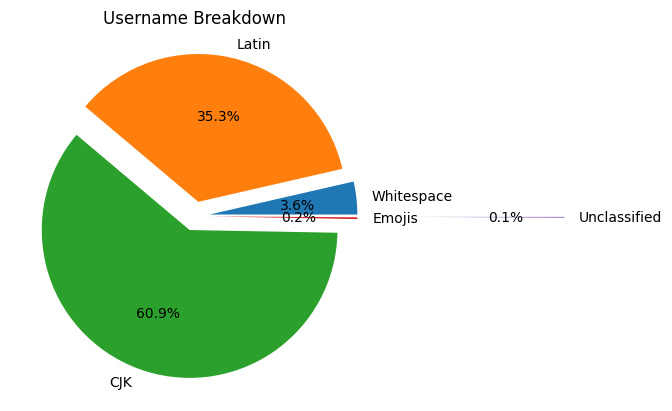

In [34]:
fig, ax = plt.subplots()
labels = 'Whitespace', 'Latin', 'CJK', 'Emojis', 'Unclassified'
explode = (0.1,0.1,0.1,0.1,1.5)
ax.pie(SimplePools[0], explode=explode, labels=labels,autopct='%1.1f%%');
ax.set_title("Username Breakdown");

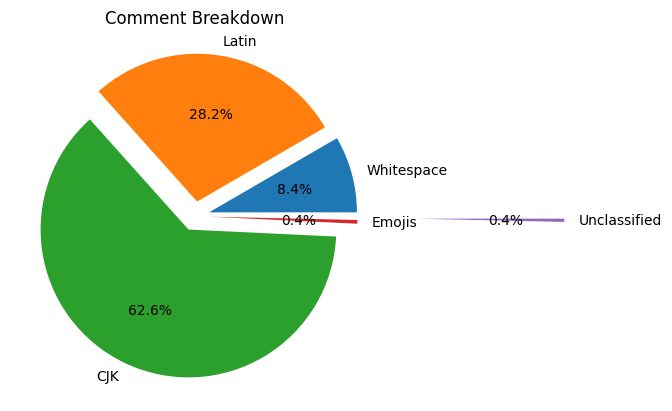

In [35]:
fig, ax = plt.subplots()
labels = 'Whitespace', 'Latin', 'CJK', 'Emojis', 'Unclassified'
explode = (0.1,0.1,0.1,0.1,1.5)
ax.pie(SimplePools[1], explode=explode, labels=labels,autopct='%1.1f%%');
ax.set_title("Comment Breakdown");

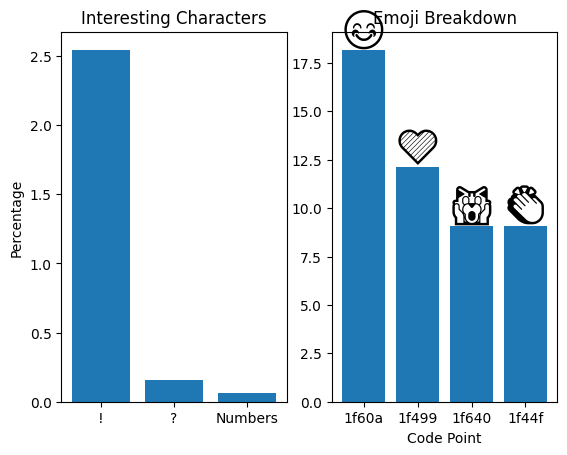

In [36]:
total_chars = np.sum(np.array(SimplePools[1]))
total_emojis = SimplePools[1][3]


fig, (ax1,ax2) = plt.subplots(1,2)
chars = '!', '?', 'Numbers'
ax1.bar(chars,commonChars[0]/total_chars*100);
ax1.set_ylabel("Percentage");
ax1.set_title("Interesting Characters");

labels = [hex(i)[2:] for i in list(commonChars[1].keys())]
up_labels = [chr(i) for i in list(commonChars[1].keys())]
values = np.array(list(commonChars[1].values()))
bar2 = ax2.bar(labels,values/total_emojis*100)
for rect, lab in zip(bar2, up_labels):
    h = rect.get_height()
    ax2.annotate(lab,(rect.get_x() + rect.get_width()/2, h+.05), ha="center", va="bottom", fontsize=25, fontname='Segoe UI Emoji')
ax2.set_title("Emoji Breakdown");
ax2.set_xlabel("Code Point");

## Word structure
We try translation tools to be able to analyze the translated word composition. 

In [37]:
from translate import Translator

In [38]:
translator = Translator(from_lang="ja",to_lang="en")

In [37]:
translation = translator.translate(cleanVideoComments_peko_1[1][1])
print(cleanVideoComments_peko_1[1][1])
print(translation)

Êú¨ÈÖç‰ø°„Åß6ÊúüÁîü„ÅÆÈÅãÂñ∂„ÅåÂñã„Å£„Å¶„Çã„Å®„Åì„ÇçÈùô„Åã„Å´„Åó„Å¶„Çã„ÅÆÊú¨ÂΩì„Å´Â•ΩÊÑüÊåÅ„Å¶„Åæ„Åó„Åü„ÄÇ„Åì„Çå„Åã„Çâ„ÇÇÈÖç‰ø°ÂøúÊè¥„Åó„Å¶„Åæ„Åô
In this delivery, I really liked that the 6th grade management is quiet where it is talking. We will continue to support delivery from now on.


The accuracy of the machine translations themselves are an unknown variable. So we analyze the Latin and Japanese variables separately to not confound the translation inaccuracy with the potential difference in culture between Latin and Japanese speakers.

We need a method of detecting whether a comment is Latin or Japanese, to do this we could look at the first `initialEnd` characters.

Average the codes and classify as Latin if average < `latin_CJK_mid`

In [125]:
# Tuning Parameters
initialEnd = 20
latin_CJK_mid = (0xFF+0x3000)/2

def autoDetect(comment)-> str:
    char_codes = np.array([ord(i) for i in comment[0:initialEnd]])
    # Remove non-Latin or CJK
    CJK_check = np.all([[char_codes>=0x3000],[char_codes<=0xFFEF]],axis=0)
    checks = np.any([[char_codes<0x2600],CJK_check],axis=0).squeeze()
    char_codes = char_codes[checks]
    avg_code = np.sum(np.array(char_codes))/len(char_codes)
    if avg_code < latin_CJK_mid:
        lang="Latin"
    else:
        lang="CJK"
    return(lang)

In [38]:
print(cleanVideoComments_peko_1[1][1])
print(autoDetect(cleanVideoComments_peko_1[1][1]))
print(translation)
print(autoDetect(translation))

Êú¨ÈÖç‰ø°„Åß6ÊúüÁîü„ÅÆÈÅãÂñ∂„ÅåÂñã„Å£„Å¶„Çã„Å®„Åì„ÇçÈùô„Åã„Å´„Åó„Å¶„Çã„ÅÆÊú¨ÂΩì„Å´Â•ΩÊÑüÊåÅ„Å¶„Åæ„Åó„Åü„ÄÇ„Åì„Çå„Åã„Çâ„ÇÇÈÖç‰ø°ÂøúÊè¥„Åó„Å¶„Åæ„Åô
CJK
In this delivery, I really liked that the 6th grade management is quiet where it is talking. We will continue to support delivery from now on.
Latin


Once we categorize a comment, we concatenate it with either EN or JA prior comments. Thus we only need to call translate once on the JA pool.

We store this in a file to avoid carrying a large sized variable.

In [127]:
def commentGrouping(comments, LatinFile = "LatinFile.txt", CJKFile = "CJKFile.txt"):
    for username, comment in comments:
        if autoDetect(comment) == "Latin":
            with open(LatinFile, 'a', encoding="utf-8") as f:
                f.write(comment)
                f.write('\n')
        else:
            with open(CJKFile, 'a', encoding="utf-8") as f:
                f.write(comment)
                f.write('\n')
    return(LatinFile,CJKFile)

In [149]:
groupFiles = commentGrouping(cleanVideoComments_peko_1); groupFiles

NameError: name 'commentGrouping' is not defined

Translate per 500 words

In [41]:
#with open(groupFiles[1],'r',encoding="utf-8") as f:
    #print(translator.translate(f.read(500)))

Jaguar is bigger than the left eye. This planning team battle is very interesting so enjoyüòä which team will win (^_^) I'm sorry that you don't like Kyushu tonkotsu, as much as I like Jiro... Kyushu ban! If you want to eat w noodles, eat udon and w is cute roulette with ukki. Congratulations on your delivery! The lottery was also fun, but it was good to see the play of Pecorachan! I can't imagine who will win! Wow, looks like a lot of fun! Thanks for always delivering! I hope this dream comes true. The swimsuit she expects is sexy and cute, noble and shows her personal charm, pounding! Ahhhhhhh, I think it's too cute. What an interesting project! I'm looking forward to the show. I liked how you called Luna ~ Peko-chan thin noodles are hard on the premise of stretching. I like it, but that's it. Thin noodles harden well. Peko-chan? Peko-chan!? I feel like I saw aüôÄüôÄüôÄ practice course, but I can't go anywhere!! It looks like it's going to be a lot of fun on a difficulty level! E

In [56]:
def commentTranslate(CJKFile="CJKFile.txt",TranslatedFile="TranslatedFile.txt"):
    translator = Translator(from_lang="ja",to_lang="en")
    with open(CJKFile,'r',encoding="utf-8") as f1:
        while(1):
            curStr=f1.read(500)
            if (curStr == ""):
                break
            else:
                with open(TranslatedFile,'a',encoding="utf-8") as f2:
                    f2.write(translator.translate(curStr))

In [47]:
#commentTranslate("CJKFile.txt","TranslatedFile.txt")

We note that we used the free translation quota from MyMemory over 12 Hours for a single video of comments - this is problematic.

For now we just edit the file to translate what was possible, and remove any warnings at the end.

In [52]:
with open("TranslatedFile.txt",'r',encoding="utf-8") as f1:
    with open("TranslatedFile2.txt", 'w', encoding="utf-8") as f2:
              f2.write(f1.read(20339))

Once translated, we tokenize words by whitespace and common punctuation.

In [71]:
def commentTokenize(commentFile):
    with open(commentFile,'r',encoding="utf-8") as f:
        curStr=f.read()
    curStr = curStr.replace("!"," ")
    curStr = curStr.replace("("," ")
    curStr = curStr.replace(")", " ")
    curStr = curStr.replace(",", " ")
    curStr = curStr.replace("?", " ")
    curStr = curStr.replace("-", " ")
    curStr = curStr.replace("~", " ")
    curStr = curStr.replace("\'", "")
    curStr = curStr.replace("\u2019", "")
    curStr = curStr.replace(".", " ")
    return curStr.split()

In [40]:
translatedCJKTokens = commentTokenize("TranslatedFile2.txt")

In [41]:
translatedCJKTokens

['Jaguar',
 'is',
 'bigger',
 'than',
 'the',
 'left',
 'eye',
 'This',
 'planning',
 'team',
 'battle',
 'is',
 'very',
 'interesting',
 'so',
 'enjoyüòä',
 'which',
 'team',
 'will',
 'win',
 '^_^',
 'Im',
 'sorry',
 'that',
 'you',
 'dont',
 'like',
 'Kyushu',
 'tonkotsu',
 'as',
 'much',
 'as',
 'I',
 'like',
 'Jiro',
 'Kyushu',
 'ban',
 'If',
 'you',
 'want',
 'to',
 'eat',
 'w',
 'noodles',
 'eat',
 'udon',
 'and',
 'w',
 'is',
 'cute',
 'roulette',
 'with',
 'ukki',
 'Congratulations',
 'on',
 'your',
 'delivery',
 'The',
 'lottery',
 'was',
 'also',
 'fun',
 'but',
 'it',
 'was',
 'good',
 'to',
 'see',
 'the',
 'play',
 'of',
 'Pecorachan',
 'I',
 'cant',
 'imagine',
 'who',
 'will',
 'win',
 'Wow',
 'looks',
 'like',
 'a',
 'lot',
 'of',
 'fun',
 'Thanks',
 'for',
 'always',
 'delivering',
 'I',
 'hope',
 'this',
 'dream',
 'comes',
 'true',
 'The',
 'swimsuit',
 'she',
 'expects',
 'is',
 'sexy',
 'and',
 'cute',
 'noble',
 'and',
 'shows',
 'her',
 'personal',
 'charm',
 '

We either can clean up the words with emojis or just remove ignore the relatively few occurences.

In [42]:
def wordBreakdown(tokenizedComments):
    wordOccurences = dict()
    for word in tokenizedComments:
        if word in wordOccurences:
            wordOccurences[word] += 1
        else:
            wordOccurences[word] = 1
    wordOccurences = dict(sorted(wordOccurences.items(),key=lambda item: item[1], reverse=True))
    return wordOccurences

We also take the lowercase of words to prevent capitalization inconsitencies.

In [43]:
translatedCJKTokens = [i.lower() for i in translatedCJKTokens]
CJKWordBreakdown = wordBreakdown(translatedCJKTokens); CJKWordBreakdown

{'the': 223,
 'to': 129,
 'i': 105,
 'it': 85,
 'a': 81,
 'is': 77,
 'of': 72,
 'and': 70,
 'you': 65,
 'fun': 56,
 'be': 53,
 'forward': 50,
 'for': 48,
 'looking': 45,
 'im': 42,
 'team': 40,
 'was': 38,
 'practice': 37,
 'that': 36,
 'thank': 36,
 'course': 35,
 'will': 33,
 'lottery': 31,
 'so': 30,
 'this': 28,
 'good': 28,
 'what': 28,
 'like': 27,
 'its': 26,
 'with': 25,
 'on': 25,
 'also': 25,
 'in': 25,
 'production': 24,
 'lot': 23,
 'chan': 23,
 'tournament': 23,
 'are': 20,
 'difficult': 20,
 'but': 19,
 'c': 19,
 'peko': 18,
 'very': 17,
 'w': 17,
 'cute': 17,
 'your': 17,
 'always': 17,
 'gw': 17,
 'part': 17,
 'meeting': 17,
 'stage': 17,
 'interesting': 16,
 'if': 16,
 'too': 16,
 'enjoy': 16,
 'seems': 16,
 'time': 16,
 'more': 16,
 'much': 15,
 'can': 15,
 'see': 14,
 'hard': 14,
 'really': 14,
 'seeing': 14,
 'at': 13,
 'all': 13,
 'which': 12,
 'delivery': 12,
 'cant': 12,
 'project': 12,
 'there': 12,
 'big': 12,
 'am': 12,
 'looks': 11,
 'from': 11,
 'look': 11,


We also get a breakdown for the Latin words.

In [72]:
LatinTokens = commentTokenize("LatinFile.txt")
LatinTokens = [i.lower() for i in LatinTokens]
LatinBreakdown = wordBreakdown(LatinTokens); LatinBreakdown

{'the': 80,
 'you': 52,
 'for': 50,
 'a': 32,
 'and': 32,
 'to': 30,
 'it': 28,
 'fun': 28,
 'i': 26,
 'thank': 25,
 'peko': 24,
 'was': 24,
 'stream': 24,
 'of': 22,
 'chan': 18,
 'im': 16,
 'that': 15,
 'with': 12,
 'on': 12,
 'this': 12,
 'so': 12,
 'have': 10,
 'will': 10,
 'be': 10,
 'but': 10,
 'pekora': 10,
 'good': 10,
 'more': 10,
 'otsupeko': 10,
 'are': 8,
 'last': 8,
 'sure': 8,
 'see': 8,
 'time': 8,
 'event': 8,
 'all': 6,
 'looking': 6,
 'forward': 6,
 'help': 6,
 'in': 6,
 'not': 6,
 'tournament': 6,
 'they': 6,
 'too': 6,
 'really': 6,
 'at': 6,
 'hope': 6,
 'your': 6,
 'getting': 6,
 'from': 6,
 'working': 6,
 'if': 6,
 'very': 6,
 'holox': 6,
 'congrats': 6,
 'win': 6,
 'minecraft': 6,
 'game': 6,
 'could': 6,
 'timestamps': 5,
 'congratulations': 5,
 'teams': 4,
 'we': 4,
 'team': 4,
 'about': 4,
 'get': 4,
 'given': 4,
 'high': 4,
 'o': 4,
 'hard': 4,
 'them': 4,
 'hololive': 4,
 'editing': 4,
 'lol': 4,
 'want': 4,
 'how': 4,
 'like': 4,
 'glad': 4,
 'there': 4,
 

### Data Visualization

Bar Charts and Word Clouds, removing some overly common words.

In [46]:
from wordcloud import WordCloud

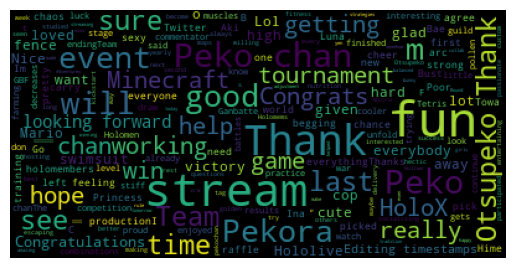

In [73]:
with open("LatinFile.txt",'r',encoding='utf-8') as f:
    wordcloud = WordCloud(max_font_size=40).generate(f.read())
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

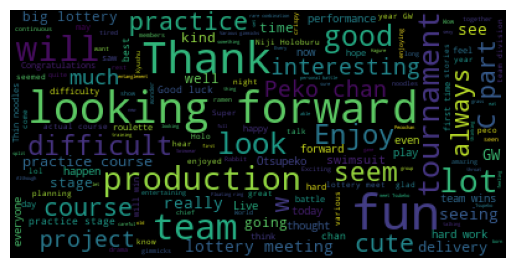

In [48]:
with open("TranslatedFile2.txt",'r',encoding='utf-8') as f:
    wordcloud = WordCloud(max_font_size=40).generate(f.read())
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Get top 10 interesting words - avoiding some common uninteresting words.

In [49]:
def interestingWords(wordBreakdown):
    interestingBreakdown = dict()
    count = 0
    uninteresting = ("the","you","to","i","a","is","of","and","pay","be",
                    "for","im","was","that","this","so","are","them","they",
                    "will","what","if","it","with","have","but","on","stream")
    for word in list(wordBreakdown):
        if word in uninteresting:
            continue
        interestingBreakdown[word]=wordBreakdown[word]
        count +=1
        if count == 10: 
            break
    return interestingBreakdown

In [74]:
interesting_LatinBreakdown = interestingWords(LatinBreakdown)
interesting_LatinBreakdown

{'fun': 28,
 'thank': 25,
 'peko': 24,
 'chan': 18,
 'pekora': 10,
 'good': 10,
 'more': 10,
 'otsupeko': 10,
 'last': 8,
 'sure': 8}

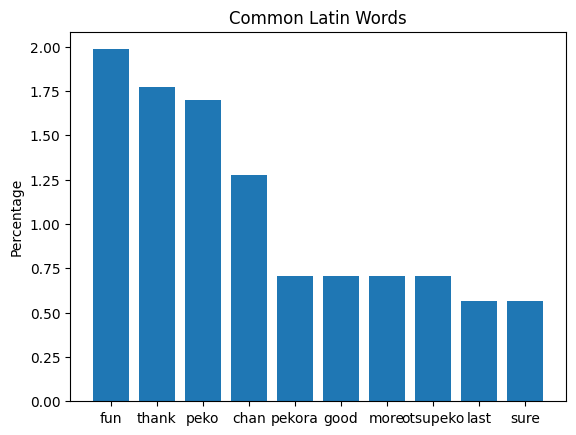

In [75]:
fig,ax = plt.subplots()
labels = interesting_LatinBreakdown.keys()
vals = np.array(list(interesting_LatinBreakdown.values()))
total = np.sum(np.array(list(LatinBreakdown.values())))
ax.bar(labels,vals/total*100)
ax.set_ylabel("Percentage")
ax.set_title("Common Latin Words");

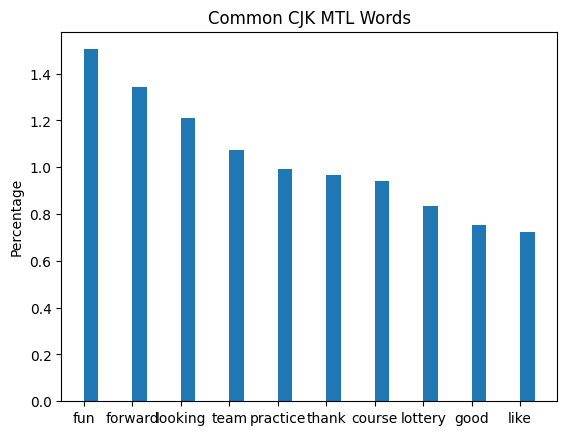

In [52]:
interesting_CJKBreakdown = interestingWords(CJKWordBreakdown)

fig,ax = plt.subplots()
labels = interesting_CJKBreakdown.keys()

vals = np.array(list(interesting_CJKBreakdown.values()))
total = np.sum(np.array(list(CJKWordBreakdown.values())))
ax.bar(labels,vals/total*100, align='edge', width=0.3)
ax.set_ylabel("Percentage")
ax.set_title("Common CJK MTL Words");

## GRU Model training

We try training a GRU LSTM based Neural Network to fill predict output given partial input. That is, try to create a comment based given a few initial words. We use a priming string of 20 characters.

We can test the predictive ability of a model trained on the Latin, Translated CJK, and Combined texts. Combining the texts and comparing input to before could tell us whether the texts are relatively similar or not.

We also simplify the alphabet to just ["a"-"z"]|"."|" ".

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm
from termcolor import colored 
import re
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
primingLength = 10

Clean up data further. Convert to characters from " .abcdefghijklmnopqrstuvwxyz", including single space at beginning of string.

In [14]:
def simplifyAlphabet(comment):
    simplified = ""
    # Non-simplified characters to replace with " " single-space
    # rather than nothing.
    spacingPunctuation = (' ', ',', '\uFF0C','-','\uFF0D','/',':','?','\uFF1F',
                          '~','\uFF5E','\uFF61', '\u3000','\u3002')
    for c in comment.lower():
        if c in spacingPunctuation:
            simplified+=" "
        elif c=='\n':
            simplified+="."
        elif ord(c) > ord('z'):
            simplified+=""
        elif ord(c) >= ord('a'):
            simplified+=c
        elif c == "." or c==" ":
            simplified+=c
    # Collapse multiple spaces
    simplified = re.sub(' +',' ', simplified)
    return simplified
        

Format Dataset and create Dataloader.

In [15]:
class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, text_file, seq_len=primingLength):
        self.seq_length=seq_len
        self.text=""
        with open(text_file, 'r', encoding="utf-8") as f:
            self.text = simplifyAlphabet(f.read())
        
        chars = sorted(list(set(self.text)))
        self.vocab_size = len(chars)
        self.char_indices = dict((c, i) for i, c in enumerate(chars))
        self.indices_char = dict((i, c) for i, c in enumerate(chars))
        self.idx = [self.char_indices[c] for c in self.text]
    def __len__(self):
        return len(self.text)-self.seq_length-1
    def __getitem__(self,k):
        x = self.idx[k:k+self.seq_length]
        t = self.idx[k+1:k+1+self.seq_length]
        return self.seq_i2v(x), torch.tensor(t, dtype=torch.long)
    def seq_i2v(self, seq):
        x = torch.zeros((len(seq), self.vocab_size))
        for k,i in enumerate(seq):
            x[k,i] = 1.
        return x
    def read_seq(self, x):
        idx = [torch.argmax(v).item() for v in x]        
        return ''.join(self.indices_char[i] for i in idx)
    def encode_seq(self, c):
        idx = [self.char_indices[cc] for cc in c]
        return self.seq_i2v(idx)

In [16]:
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, gru_layers=1):
        self.losses = []
        self.input_dim = input_size
        self.hidden_dim = hidden_size
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size ,num_layers=gru_layers, 
                          batch_first=True)
        
        self.relu1 = nn.ReLU()
        self.linear = nn.Linear(in_features=hidden_size, out_features=input_size)
        self.relu2 = nn.ReLU()
    def output(self, h):
        '''
        After setting up GRU, return output as Log Softmax of chars
        '''
        return self.relu2(self.linear(self.relu1(h)))
    
    def forward(self,x):
        '''
        Given batch of sequences, returns batch of output sequences
        '''
        x = x.to(device)
        
        out, h = self.gru(x)
        return self.output(out)
        
    def bptt(self, dl, epochs=10, loss_fcn=nn.CrossEntropyLoss(), lr=0.001):
        '''
        Batches form L*N*Hin
            L - Number of sequences/samples in batch (Batch size?)
            N - Length of each sequence/sample (10 Word Sequences?)
            Hin - Dimension of each input (Vocab Size?)
        '''
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x,t in dl:
                y = self(x)   # process the batch of sequences
                # Go through output sequences, and compute loss
                y = y.reshape(y.shape[0],y.shape[2],y.shape[1])
                loss = loss_fcn(y,t)
                # Optimization Steps
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.detach().cpu().item()
            self.losses.append(total_loss/len(dl))
        plt.plot(self.losses)

    def predict(self, x, primingLength=20, n=10):
        '''
        Inputs:
            x - TxI input sequence
            n - how many output ts to predict
        Outputs:
            y - nxI output of n outputs predicted
        '''
        with torch.no_grad():
            # Priming GRU with Sequence
            z,h = self.gru(x)
            # Get final result as next char
            y = self.output(z)[primingLength-1]
            pred = [y]
            for i in range(n-1):
                # Make one-hot 
                x = torch.argmax(y)
                x = nn.functional.one_hot(x, num_classes= self.input_dim)
                # Add dimension and cast typing for compatibility with h
                x = torch.unsqueeze(x,0)
                x = x.to(h.dtype)
                z,h = self.gru(x,h)
                y = self.output(z)
                pred.append(torch.squeeze(y,0))
        return torch.stack(pred,dim=0)

In [17]:
cds = CommentDataset("LatinFile.txt", seq_len=10)
print(cds.text[0:500])
x, t = cds[0] # Get sequence beginning from 0
print(f'Sample input: "{cds.read_seq(x)}"')

this event gonna be hype.all teams are looking forward to the chaos of the production.i agree with peko chan we need sexy swimsuits for holomembers. .i have a feeling that team b will be pretty strong but i cant help but cheer for team c. go aki chan.im about to bust.why in the world was luna picked last a princess should get to pick her own and first not be given the last one left. poor hime shes been on a mario training arc and everything.thanks for the stream peko chan. looking forward to thi
Sample input: "this event"


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:14<00:00,  1.43s/it]


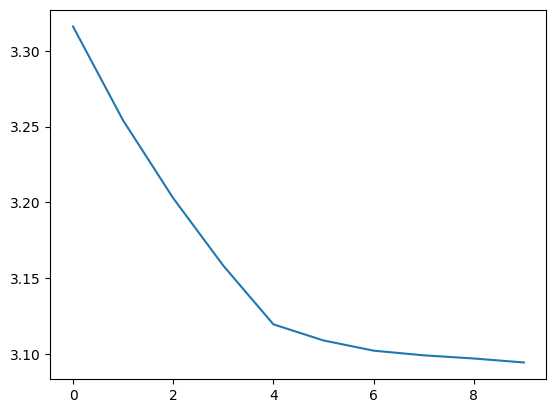

In [449]:
commentdl1 = torch.utils.data.DataLoader(cds, batch_size=16, shuffle=True)
net2 = MyGRU(cds.vocab_size,256,gru_layers=1)
net2.bptt(commentdl1, epochs=10)

In [18]:
# torch.save(net2.cpu(), 'mygru2.pt')
net2 = torch.load('mygru2.pt').to(device)

In [61]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(cds))
rs = cds.read_seq
s = cds.__getitem__(k)[0].to(device)
n = 100

# Feed seq to net, ask for next n chars
pred_seq = net2.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
#snext = cds.__getitem__(k+cds.seq_length)[0]  # the following sequence
snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
print(f'Actual:       {rs(s)+snext}')

Input:        n question
Prediction:   n question                       eeeeeeeeeeeeggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg
Actual:       n questions im always willing to help you. im very passionate about working out and have studied it for a long


Running the above cell a few times, we see that the results are generally not too great. 

We try smaller batches, so that each sequence is less confounded with others.

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [20:54<00:00, 125.43s/it]


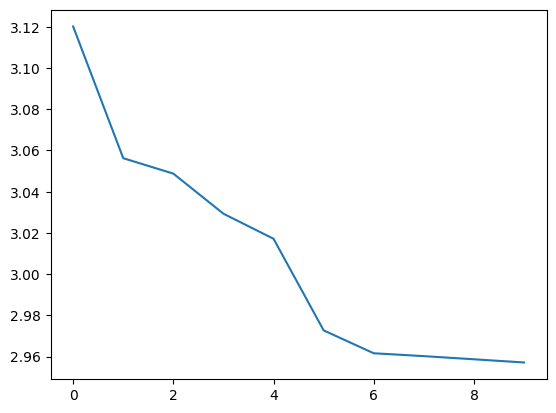

In [16]:
commentdl2 = torch.utils.data.DataLoader(cds, batch_size=4, shuffle=True)
net3 = MyGRU(cds.vocab_size,256,gru_layers=1)
net3.bptt(commentdl2, epochs=10)

In [150]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(cds))
rs = cds.read_seq
s = cds.__getitem__(k)[0].to(device)
n = 100

# Feed seq to net, ask for next n chars
pred_seq = net3.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
#snext = cds.__getitem__(k+cds.seq_length)[0]  # the following sequence
snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
print(f'Actual:       {rs(s)+snext}')

Input:        .thank for
Prediction:   .thank for                                                                                                    
Actual:       .thank for the fun stream pekora chan.thank you for the raffle stream peko high chance of new swimsuit o . o l


In [19]:
#torch.save(net3.cpu(), 'mygru3.pt')
net3 = torch.load('mygru3.pt').to(device)

Training often results in very poor models.

Setting batch size to 1 doesn't appear to give a very good result.
We also try a variant on the GRU which removes the batching completely.

In [29]:
class MyGRU2(nn.Module):
    def __init__(self, input_size, hidden_size, gru_layers=1, primer_len=10):
        self.losses = []
        self.input_dim = input_size
        self.hidden_dim = hidden_size
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,num_layers=gru_layers, 
                          batch_first=True)
        
        self.relu1 = nn.ReLU()
        self.linear = nn.Linear(in_features=hidden_size, out_features=input_size)
        self.relu2 = nn.ReLU()
    def output(self, z):
        '''
        After setting up GRU, return output as Log Softmax of chars
        '''
        return self.relu2(self.linear(self.relu1(z)))
    
    def forward(self,x):
        '''
        Given batch of sequences, returns batch of output sequences
        '''
        x = x.to(device)
        
        out, h = self.gru(x)
        return self.output(out)
        
    def bptt(self, dl, epochs=10, loss_fcn=nn.CrossEntropyLoss(), lr=0.001):
        '''
        Batches form L*N*Hin
            L - Number of sequences/samples in batch (Batch size?)
            N - Length of each sequence/sample (10 Word Sequences?)
            Hin - Dimension of each input (Vocab Size?)
        '''
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x,t in dl:
                y = self(x)   # process the batch of sequences
                # Go through output sequences, and compute loss
                loss = torch.tensor(0., device=device, requires_grad=True)
                # Removes effect of batching
                for ys,ts in zip(y,t.to(device)):
                    loss = loss + loss_fcn(ys, ts)
                # Optimization Steps
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.detach().cpu().item()
            self.losses.append(total_loss/len(dl))
        plt.plot(self.losses)

    def predict(self, x, primingLength=20, n=10):
        '''
        Inputs:
            x - TxI input sequence
            n - how many output ts to predict
        Outputs:
            y - nxI output of n outputs predicted
        '''
        with torch.no_grad():
            # Priming GRU with Sequence
            z,h = self.gru(x)
            # Get final result as next char
            y = self.output(z)[primingLength-1]
            pred = [y]
            for i in range(n-1):
                # Make one-hot 
                x = torch.argmax(y)
                x = nn.functional.one_hot(x, num_classes= self.input_dim)
                # Add dimension and cast typing for compatibility with h
                x = torch.unsqueeze(x,0)
                x = x.to(h.dtype)
                z,h = self.gru(x,h)
                y = self.output(z)
                pred.append(torch.squeeze(y,0))
        return torch.stack(pred,dim=0)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [04:48<00:00, 28.84s/it]


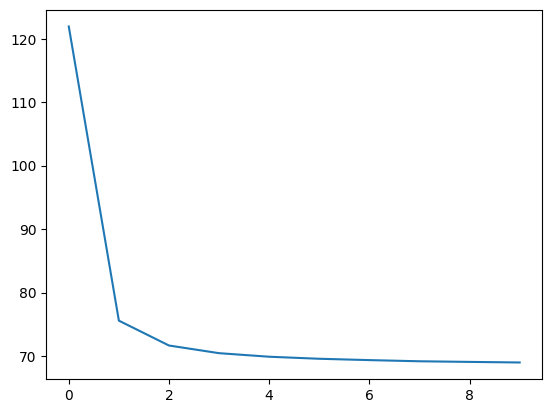

In [160]:
net1 = MyGRU2(cds.vocab_size,256,gru_layers=1)
net1.bptt(commentdl, epochs=10)

In [21]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(cds))
rs = cds.read_seq
s = cds.__getitem__(k)[0].to(device)
n = 50

# Feed seq to net, ask for next n chars
pred_seq = net1.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
#snext = cds.__getitem__(k+cds.seq_length)[0]  # the following sequence
snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
print(f'Actual:       {rs(s)+snext}')

NameError: name 'net1' is not defined

In [22]:
#torch.save(net1.cpu(), 'mygru1.pt')
net1 = torch.load('mygru1.pt').to(device)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [11:34<00:00, 69.49s/it]


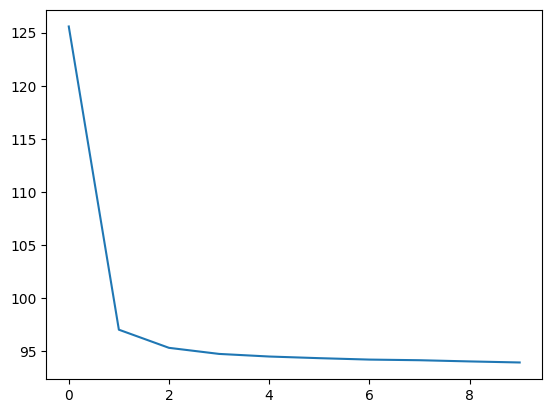

In [146]:
commentdl3 = torch.utils.data.DataLoader(cds, batch_size=128, shuffle=True)
net4 = MyGRU2(cds.vocab_size,512,gru_layers=1)
net4.bptt(commentdl, epochs=10)

In [198]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(cds))
rs = cds.read_seq
s = cds.__getitem__(k)[0].to(device)
n = 50

# Feed seq to net, ask for next n chars
pred_seq = net4.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
#snext = cds.__getitem__(k+cds.seq_length)[0]  # the following sequence
snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
print(f'Actual:       {rs(s)+snext}')

Input:        e hype.all
Prediction:   e hype.all teams a e le to t e   ool te mentate steeam   ool
Actual:       e hype.all teams are looking forward to the chaos of the pro


In [23]:
#torch.save(net4.cpu(), 'mygru4.pt')
net4 = torch.load('mygru4.pt').to(device)

While the training time is lengthy, the results do appear to be significantly better.

In [15]:
translatedDS = CommentDataset("TranslatedFile2.txt",seq_len=10)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [03:04<00:00, 18.49s/it]


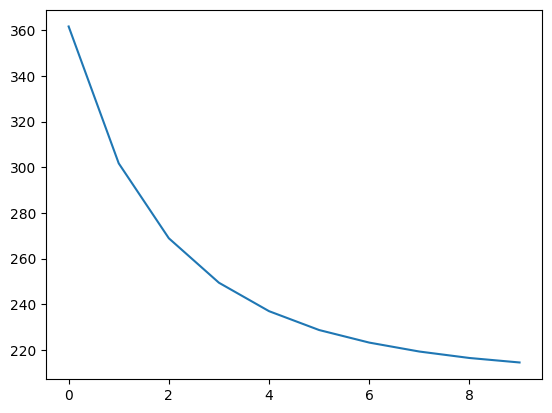

In [180]:
translatedDL = torch.utils.data.DataLoader(translatedDS, batch_size=128, shuffle=True)
net5 = MyGRU2(translatedDS.vocab_size,512,gru_layers=1)
net5.bptt(translatedDL, epochs=10)

In [16]:
# torch.save(net5.cpu(), 'mygru5.pt')
net5 = torch.load('mygru5.pt').to(device)

In [528]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(translatedDS))
rs = translatedDS.read_seq
s = translatedDS.__getitem__(k)[0].to(device)
n = 100

# Feed seq to net, ask for next n chars
pred_seq = net5.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
# the following sequence
snext = translatedDS.text[k+translatedDS.seq_length:k+cds.seq_length+n]
print(f'Actual:       {rs(s)+snext}')

Input:         congratul
Prediction:    congratulations on to ta an to tea  an interesting so it see so i an to tea  anteresting to tea  anteresting 
Actual:        congratulations on your delivery the lottery was also fun but it was good to see the play of pecorachan i can


We try adding more gru layers.

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [06:22<00:00, 38.28s/it]


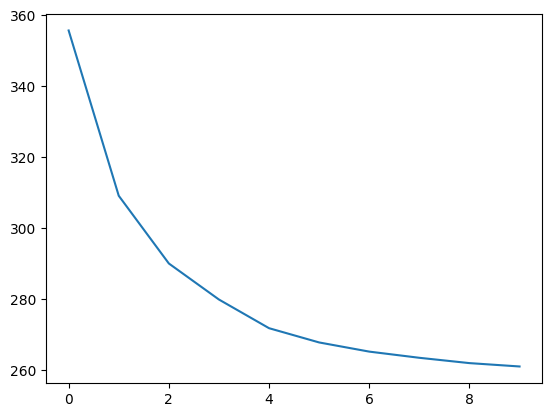

In [182]:
translatedDL = torch.utils.data.DataLoader(translatedDS, batch_size=128, shuffle=True)
net6 = MyGRU2(translatedDS.vocab_size,512,gru_layers=2)
net6.bptt(translatedDL, epochs=10)

In [184]:
#torch.save(net6.cpu(), 'mygru6.pt')
net6 = torch.load('mygru6.pt').to(device)

In [585]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(translatedDS))
rs = translatedDS.read_seq
s = translatedDS.__getitem__(k)[0].to(device)
n = 100

# Feed seq to net, ask for next n chars
pred_seq = net6.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+colored(rs(pred_seq), "red")}')
# the following sequence
snext = translatedDS.text[k+translatedDS.seq_length:k+cds.seq_length+n]
print(f'Actual:       {rs(s)+snext}')

Input:        men ok... 
Prediction:   men ok... lol than the tea the tea the tea   ot the to the to the to the to the to the to the to the to the to
Actual:       men ok... lol thank you for talking to me a lot it was so much fun lottery meeting teami wonder who is going t


We can also try vectorizing the words themselves, to eliminate some of the nonsense.

In [30]:
def simplifyAlphabet2(comment):
    simplified = ""
    # Non-simplified characters to replace with " " single-space
    # rather than nothing.
    spacingPunctuation = (' ', ',', '\uFF0C','-','\uFF0D','/',':','?','\uFF1F',
                          '~','\uFF5E','\uFF61', '\u3000','\u3002')
    for c in comment.lower():
        if c in spacingPunctuation:
            simplified+=" "
        elif c=='\n':
            simplified+=" . "
        elif ord(c) > ord('z'):
            simplified+=""
        elif ord(c) >= ord('a'):
            simplified+=c
        elif c == "." or c==" ":
            simplified+= " " + c + " "
    # remove doubled periods
    simplified = re.sub("\. +\.",".",simplified)
    return simplified

In [46]:
class CommentDataset2(torch.utils.data.Dataset):
    def __init__(self, text_file, seq_len=primingLength):
        self.seq_length=seq_len
        self.text=""
        with open(text_file, 'r', encoding="utf-8") as f:
            self.text = simplifyAlphabet2(f.read()).split()
        
        words = sorted(list(set(self.text)))
        self.vocab_size = len(words)
        self.word_indices = dict((w, i) for i, w in enumerate(words))
        self.indices_word = dict((i, w) for i, w in enumerate(words))
        self.idx = [self.word_indices[w] for w in self.text]
    def __len__(self):
        return len(self.text)-self.seq_length-1
    def __getitem__(self,k):
        x = self.idx[k:k+self.seq_length]
        t = self.idx[k+1:k+1+self.seq_length]
        return self.seq_i2v(x), torch.tensor(t, dtype=torch.long)
    def seq_i2v(self, seq):
        x = torch.zeros((len(seq), self.vocab_size))
        for k,i in enumerate(seq):
            x[k,i] = 1.
        return x
    def read_seq(self, x):
        idx = [torch.argmax(v).item() for v in x]        
        return ' '.join(self.indices_word[i] for i in idx)
    def encode_seq(self, w):
        idx = [self.word_indices[ww] for ww in w]
        return self.seq_i2v(idx)

In [47]:
cds2 = CommentDataset2("LatinFile.txt", seq_len=10)
print(len(cds2))
print(cds2.text[0:20])
x, t = cds2[0] # Get sequence beginning from 0
print(f'Sample input: "{cds2.read_seq(x)}"')

354
['this', 'event', 'gonna', 'be', 'hype', '.', 'all', 'teams', 'are', 'looking', 'forward', 'to', 'the', 'chaos', 'of', 'the', 'production', '.', 'i', 'agree']
Sample input: "this event gonna be hype . all teams are looking"


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [04:05<00:00, 24.53s/it]


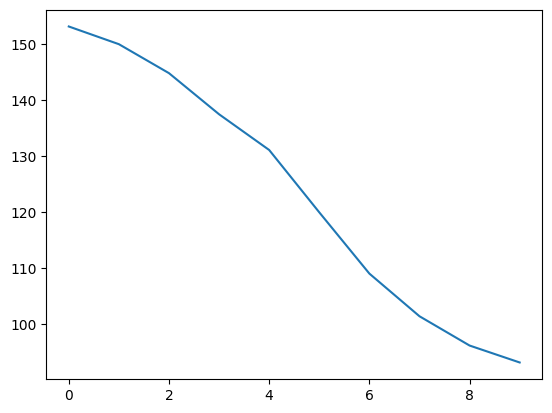

In [720]:
wordnet1 = MyGRU2(cds2.vocab_size,4096,gru_layers=1)
wordnet1.bptt(commentdl4, epochs=10)

In [37]:
#torch.save(wordnet1.cpu(), 'mywordgru1.pt')
wordnet1 = torch.load('mywordgru1.pt').to(device)

In [721]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(cds2))
rs = cds2.read_seq
s = cds2.__getitem__(k)[0].to(device)
n = 20

# Feed seq to net, ask for next n chars
pred_seq = wordnet1.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+" "+colored(rs(pred_seq), "red")}')
#snext = cds.__getitem__(k+cds.seq_length)[0]  # the following sequence
snext = " ".join(cds2.text[k+cds2.seq_length:k+cds2.seq_length+n])
print(f'Actual:       {rs(s)+" "+snext}')

Input:        out . if you ever have fitness nutrition questions im
Prediction:   out . if you ever have fitness nutrition questions im sexy cooler to . . mario on a and bae are looking forward to the . . the raffle .
Actual:       out . if you ever have fitness nutrition questions im always willing to help you . im very passionate about working out and have studied it for a long time


In [197]:
translatedDS2 = CommentDataset2("TranslatedFile2.txt",seq_len=10)
print(len(translatedDS2))
print(f'vocab size: {translatedDS2.vocab_size}')
print(translatedDS2.text[0:20])
x, t = translatedDS2[0] # Get sequence beginning from 0
print(f'Sample input: "{translatedDS2.read_seq(x)}"')

3798
vocab size: 604
['jaguar', 'is', 'bigger', 'than', 'the', 'left', 'eye', '.', 'this', 'planning', 'team', 'battle', 'is', 'very', 'interesting', 'so', 'enjoy', 'which', 'team', 'will']
Sample input: "jaguar is bigger than the left eye . this planning"


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15/15 [10:15<00:00, 41.01s/it]


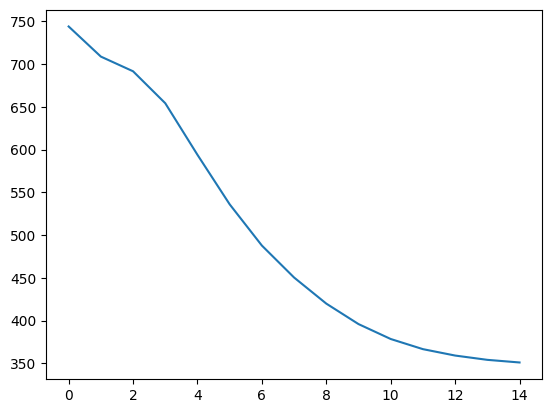

In [734]:
translatedDL2 = torch.utils.data.DataLoader(translatedDS2, batch_size=128, shuffle=True)
wordnet3 = MyGRU2(translatedDS2.vocab_size,2048,gru_layers=1)
wordnet3.bptt(translatedDL2, epochs=15)

In [196]:
# torch.save(wordnet3.cpu(), 'mywordgru2.pt')
wordnet3 = torch.load('mywordgru2.pt').to(device)

In [738]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(translatedDS2))
rs = translatedDS2.read_seq
s = translatedDS2.__getitem__(k)[0].to(device)
n = 20

# Feed seq to net, ask for next n chars
pred_seq = wordnet3.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+" "+colored(rs(pred_seq), "red")}')
# the following sequence
snext = " ".join(translatedDS2.text[k+translatedDS2.seq_length:k+translatedDS2.seq_length+n])
print(f'Actual:       {rs(s)+" "+snext}')

Input:        various reactions w . the room is all set and
Prediction:   various reactions w . the room is all set and im looking forward to seeing . thank you very interesting enjoy the best to gw to be the best to
Actual:       various reactions w . the room is all set and im looking forward to seeing what chemistry happens lucky for you it was fun the training course was difficult its


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15/15 [31:15<00:00, 125.03s/it]


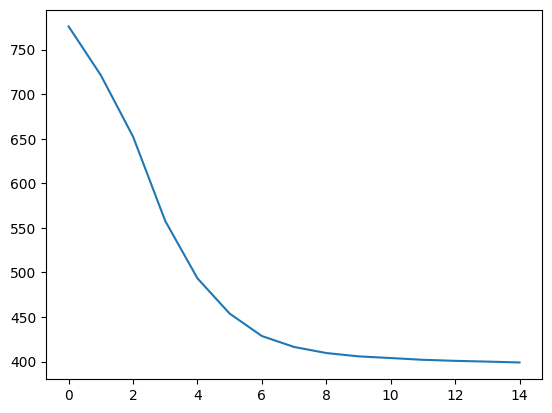

In [739]:
wordnet4 = MyGRU2(translatedDS2.vocab_size,4096,gru_layers=1)
wordnet4.bptt(translatedDL2, epochs=12)

In [202]:
#torch.save(wordnet4.cpu(), 'mywordgru4.pt')
wordnet4 = torch.load('mywordgru4.pt').to(device)

In [746]:
# Choose a random seed sequence
k = np.random.randint(0, high=len(translatedDS2))
rs = translatedDS2.read_seq
s = translatedDS2.__getitem__(k)[0].to(device)
n = 20

# Feed seq to net, ask for next n chars
pred_seq = wordnet4.predict(s,primingLength = primingLength, n=n).cpu()
print(f'Input:        {rs(s)}')
print(f'Prediction:   {rs(s)+" "+colored(rs(pred_seq), "red")}')
# the following sequence
snext = " ".join(translatedDS2.text[k+translatedDS2.seq_length:k+translatedDS2.seq_length+n])
print(f'Actual:       {rs(s)+" "+snext}')

Input:        . thin noodles harden well . peko chan peko chan
Prediction:   . thin noodles harden well . peko chan peko chan i feel like i are in a . its a team thats going to . the . practice and it
Actual:       . thin noodles harden well . peko chan peko chan i feel like i saw a practice course but i cant go anywhere it looks like its going to be


We then test the relative accuracy of each, with respect to training data.

In [28]:
# net2: char prediction, batches of 16
totCorrect_net2 = []
initCorrect_net2 = []
# Sampled Start Points
samples = 500
np.random.seed(1234)
for k in np.random.randint(0, high=len(cds)-n, size=samples):
    rs = cds.read_seq
    s = cds.__getitem__(k)[0].to(device)
    # Predict n chars ahead
    n=50
    pred_seq = rs(net2.predict(s,primingLength=primingLength,n=n).cpu())
    snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_net2.append(len(pred_seq)-len(incorrect))
    initCorrect_net2.append(incorrect[0])
print(totCorrect_net2)
print(initCorrect_net2)

[8, 7, 8, 6, 10, 4, 7, 5, 6, 6, 9, 9, 5, 7, 2, 8, 4, 6, 5, 5, 3, 5, 7, 5, 10, 5, 8, 8, 5, 3, 8, 6, 8, 7, 4, 9, 4, 2, 7, 8, 3, 7, 6, 6, 9, 4, 4, 9, 6, 8, 7, 7, 7, 7, 8, 6, 7, 4, 6, 7, 6, 7, 4, 6, 8, 7, 9, 3, 4, 6, 8, 2, 5, 8, 3, 4, 8, 8, 8, 7, 8, 7, 5, 6, 4, 6, 5, 8, 3, 4, 3, 7, 7, 6, 10, 9, 6, 9, 8, 1, 6, 7, 4, 9, 6, 8, 6, 2, 6, 11, 3, 7, 5, 7, 7, 6, 5, 6, 4, 5, 4, 4, 7, 5, 2, 1, 5, 4, 5, 5, 5, 8, 9, 5, 1, 3, 2, 9, 4, 4, 8, 6, 3, 5, 6, 4, 4, 3, 8, 5, 4, 5, 5, 5, 6, 7, 6, 8, 5, 7, 5, 6, 2, 2, 8, 3, 2, 3, 2, 5, 4, 2, 7, 6, 6, 2, 6, 6, 4, 7, 6, 10, 9, 4, 7, 0, 2, 5, 3, 7, 10, 8, 5, 7, 3, 4, 8, 5, 4, 5, 3, 7, 7, 4, 9, 0, 6, 9, 5, 4, 7, 7, 9, 5, 9, 2, 3, 6, 6, 7, 8, 6, 7, 8, 7, 5, 6, 7, 7, 10, 6, 5, 6, 6, 3, 7, 4, 8, 3, 4, 8, 11, 5, 3, 4, 3, 3, 6, 2, 6, 9, 6, 3, 5, 9, 6, 5, 7, 1, 9, 4, 8, 7, 4, 3, 3, 4, 7, 5, 2, 5, 10, 5, 7, 7, 6, 7, 6, 1, 6, 4, 5, 10, 3, 2, 7, 9, 7, 6, 5, 7, 8, 10, 2, 4, 8, 5, 7, 6, 4, 6, 7, 5, 6, 10, 5, 4, 4, 7, 3, 7, 6, 7, 7, 6, 4, 7, 8, 8, 7, 2, 5, 7, 1, 7, 6, 8, 8, 4, 

In [29]:
# net3: char prediction, batches of 4 
totCorrect_net3 = []
initCorrect_net3 = []
# Sampled Start Points
samples = 500
# Number of Predicted characters
n = 50
np.random.seed(1234)
for k in np.random.randint(0, high=len(cds)-n, size=samples):
    rs = cds.read_seq
    s = cds.__getitem__(k)[0].to(device)
    pred_seq = rs(net3.predict(s,primingLength=primingLength,n=n).cpu())
    snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_net3.append(len(pred_seq)-len(incorrect))
    initCorrect_net3.append(incorrect[0])
print(totCorrect_net3)
print(initCorrect_net3)

[8, 7, 9, 9, 9, 11, 10, 9, 10, 9, 9, 10, 8, 12, 10, 11, 9, 10, 8, 9, 10, 9, 9, 10, 11, 11, 8, 9, 10, 8, 9, 6, 9, 10, 5, 11, 9, 10, 10, 9, 8, 10, 9, 8, 10, 9, 8, 10, 11, 9, 9, 9, 8, 11, 9, 10, 12, 11, 12, 11, 7, 11, 9, 8, 9, 8, 9, 9, 9, 9, 10, 9, 11, 11, 10, 7, 12, 11, 10, 7, 11, 11, 7, 12, 9, 11, 11, 9, 10, 8, 10, 11, 9, 8, 10, 12, 9, 10, 10, 8, 7, 8, 10, 10, 9, 11, 10, 11, 7, 11, 7, 12, 9, 11, 10, 8, 10, 8, 8, 8, 10, 8, 9, 6, 11, 10, 6, 8, 7, 8, 7, 9, 12, 8, 10, 9, 11, 12, 6, 5, 8, 9, 9, 10, 11, 11, 6, 7, 9, 9, 8, 9, 9, 8, 10, 10, 10, 10, 9, 10, 10, 10, 8, 11, 10, 8, 9, 8, 9, 9, 10, 8, 9, 8, 8, 9, 9, 8, 8, 9, 10, 11, 9, 10, 11, 8, 8, 8, 11, 8, 9, 9, 10, 7, 8, 8, 9, 11, 9, 8, 8, 9, 9, 6, 11, 7, 7, 9, 11, 9, 11, 9, 9, 10, 10, 11, 8, 9, 9, 9, 9, 9, 9, 9, 8, 9, 8, 7, 7, 10, 8, 9, 5, 8, 10, 9, 7, 11, 8, 8, 11, 9, 11, 8, 8, 8, 8, 8, 9, 9, 11, 11, 8, 10, 7, 10, 7, 8, 9, 10, 7, 8, 8, 7, 11, 11, 11, 10, 11, 9, 10, 9, 11, 8, 8, 9, 7, 11, 6, 9, 8, 9, 11, 8, 10, 11, 9, 9, 9, 7, 8, 12, 9, 11, 11, 

In [30]:
# net1: char prediction, no batching, 256 GRU weights
totCorrect_net1 = []
initCorrect_net1 = []
# Sampled Start Points
samples = 500
# Number of Predicted characters
n = 50
np.random.seed(1234)
for k in np.random.randint(0, high=len(cds)-n, size=samples):
    rs = cds.read_seq
    s = cds.__getitem__(k)[0].to(device)
    pred_seq = rs(net1.predict(s,primingLength=primingLength,n=n).cpu())
    snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_net1.append(len(pred_seq)-len(incorrect))
    initCorrect_net1.append(incorrect[0])
print(totCorrect_net1)
print(initCorrect_net1)

[5, 10, 7, 17, 3, 8, 11, 7, 9, 8, 5, 8, 5, 11, 14, 7, 3, 6, 3, 6, 7, 8, 7, 11, 9, 10, 10, 4, 10, 12, 5, 5, 7, 9, 8, 9, 6, 6, 8, 5, 4, 8, 6, 5, 6, 9, 6, 24, 7, 9, 7, 9, 13, 4, 5, 5, 6, 8, 9, 6, 9, 7, 10, 7, 8, 3, 5, 5, 3, 6, 14, 2, 11, 5, 5, 13, 6, 3, 7, 9, 5, 6, 12, 11, 5, 5, 11, 7, 8, 8, 11, 7, 5, 11, 7, 5, 8, 12, 2, 4, 9, 8, 13, 14, 8, 7, 8, 12, 9, 7, 6, 12, 2, 7, 8, 5, 6, 7, 15, 6, 7, 6, 8, 6, 6, 6, 16, 8, 8, 4, 14, 8, 11, 13, 14, 5, 7, 7, 5, 8, 8, 19, 7, 5, 7, 14, 6, 19, 5, 7, 4, 3, 9, 10, 4, 12, 16, 7, 5, 10, 5, 10, 8, 9, 7, 17, 10, 26, 21, 8, 23, 4, 8, 7, 3, 3, 9, 6, 8, 3, 5, 13, 5, 10, 8, 14, 6, 5, 7, 3, 9, 4, 10, 9, 19, 7, 6, 8, 6, 5, 26, 8, 9, 2, 8, 3, 6, 5, 10, 10, 6, 7, 6, 4, 8, 7, 19, 5, 3, 8, 4, 6, 8, 14, 6, 10, 7, 21, 12, 7, 10, 11, 4, 8, 9, 7, 7, 13, 11, 4, 6, 4, 11, 8, 5, 6, 13, 11, 22, 8, 14, 8, 11, 7, 9, 8, 11, 11, 8, 15, 5, 9, 11, 5, 6, 10, 9, 11, 16, 3, 5, 9, 10, 9, 4, 5, 10, 10, 2, 19, 5, 5, 7, 11, 9, 12, 5, 1, 22, 10, 14, 6, 11, 6, 14, 8, 7, 4, 6, 6, 6, 11, 6, 12,

In [33]:
# net4: char prediction, no batching, 512 GRU weights
totCorrect_net4 = []
initCorrect_net4 = []
# Sampled Start Points
samples = 500
# Number of Predicted characters
n = 50
np.random.seed(1234)
for k in np.random.randint(0, high=len(cds)-n, size=samples):
    rs = cds.read_seq
    s = cds.__getitem__(k)[0].to(device)
    pred_seq = rs(net4.predict(s,primingLength=primingLength,n=n).cpu())
    snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_net4.append(len(pred_seq)-len(incorrect))
    initCorrect_net4.append(incorrect[0])
print(totCorrect_net4)
print(initCorrect_net4)

[5, 6, 10, 8, 4, 11, 11, 11, 8, 12, 7, 5, 8, 8, 3, 5, 9, 8, 8, 10, 4, 6, 10, 11, 8, 12, 9, 6, 13, 9, 6, 5, 7, 7, 5, 6, 6, 9, 5, 7, 5, 9, 7, 4, 7, 15, 7, 10, 7, 6, 12, 15, 8, 7, 7, 9, 3, 8, 11, 7, 9, 5, 9, 9, 10, 5, 7, 11, 6, 11, 11, 8, 10, 6, 5, 5, 9, 10, 3, 6, 10, 6, 11, 5, 11, 7, 9, 7, 6, 8, 6, 10, 4, 8, 6, 6, 9, 9, 8, 7, 9, 9, 9, 13, 6, 10, 8, 7, 9, 10, 4, 9, 13, 11, 9, 4, 8, 11, 11, 3, 8, 9, 4, 1, 7, 3, 2, 10, 8, 10, 8, 7, 8, 4, 13, 11, 6, 7, 5, 5, 6, 8, 6, 1, 7, 9, 11, 13, 6, 12, 6, 5, 9, 5, 8, 6, 5, 6, 3, 15, 8, 8, 10, 10, 5, 13, 5, 7, 8, 8, 8, 12, 4, 13, 5, 7, 3, 2, 5, 6, 11, 12, 7, 7, 8, 11, 4, 5, 5, 9, 10, 5, 10, 6, 7, 5, 7, 8, 5, 9, 7, 12, 15, 3, 13, 3, 3, 7, 12, 5, 8, 13, 9, 4, 3, 9, 7, 6, 7, 11, 5, 6, 12, 5, 7, 9, 6, 7, 8, 6, 7, 10, 2, 10, 5, 12, 6, 10, 5, 8, 8, 10, 9, 10, 7, 7, 7, 9, 6, 6, 13, 10, 5, 4, 5, 12, 9, 7, 14, 11, 8, 12, 11, 5, 7, 4, 8, 12, 15, 3, 5, 10, 12, 11, 5, 9, 6, 6, 6, 8, 7, 7, 9, 5, 6, 6, 7, 10, 6, 6, 15, 11, 13, 7, 9, 8, 12, 9, 5, 7, 7, 11, 5, 10, 7, 9,

In [24]:
# net5: char prediction, no batching, 512 GRU weights, more complex text
totCorrect_net5 = []
initCorrect_net5 = []
# Sampled Start Points
samples = 500
# Number of Predicted characters
n = 50
np.random.seed(1234)
for k in np.random.randint(0, high=len(cds)-n, size=samples):
    rs = cds.read_seq
    s = cds.__getitem__(k)[0].to(device)
    pred_seq = rs(net5.predict(s,primingLength=primingLength,n=n).cpu())
    snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_net5.append(len(pred_seq)-len(incorrect))
    initCorrect_net5.append(incorrect[0])
print(totCorrect_net5)
print(initCorrect_net5)

[5, 6, 12, 6, 4, 2, 6, 7, 4, 6, 4, 12, 4, 4, 6, 2, 7, 4, 6, 4, 7, 4, 5, 8, 4, 10, 7, 3, 2, 5, 4, 8, 6, 11, 3, 7, 3, 5, 6, 7, 7, 8, 9, 8, 6, 5, 1, 8, 4, 7, 6, 3, 7, 3, 7, 4, 7, 8, 5, 6, 7, 4, 8, 6, 9, 4, 10, 5, 5, 4, 11, 1, 6, 6, 9, 3, 8, 11, 5, 5, 3, 4, 7, 1, 7, 2, 3, 6, 7, 2, 7, 5, 7, 4, 3, 6, 7, 6, 8, 3, 7, 4, 6, 9, 6, 2, 7, 6, 7, 6, 5, 5, 8, 5, 5, 8, 5, 5, 4, 5, 3, 6, 7, 3, 11, 8, 4, 5, 1, 5, 4, 2, 5, 10, 6, 5, 2, 5, 7, 3, 6, 11, 5, 3, 4, 7, 5, 5, 4, 8, 6, 7, 6, 6, 5, 5, 5, 7, 9, 12, 5, 1, 3, 4, 9, 4, 7, 4, 5, 5, 5, 5, 5, 5, 3, 4, 7, 8, 4, 3, 2, 7, 4, 8, 10, 4, 5, 8, 6, 6, 3, 6, 5, 5, 6, 4, 8, 4, 7, 12, 4, 9, 3, 7, 9, 2, 3, 10, 10, 7, 5, 6, 5, 5, 7, 1, 6, 4, 7, 8, 6, 4, 9, 7, 6, 2, 7, 4, 7, 3, 2, 2, 6, 6, 3, 3, 4, 8, 6, 5, 6, 5, 3, 6, 5, 6, 12, 12, 5, 6, 4, 10, 6, 6, 6, 9, 11, 3, 6, 2, 9, 3, 3, 4, 5, 6, 4, 6, 7, 6, 4, 3, 10, 4, 5, 0, 6, 6, 3, 11, 5, 6, 2, 6, 2, 8, 10, 8, 14, 3, 0, 6, 7, 11, 7, 3, 5, 9, 4, 5, 7, 5, 6, 4, 4, 8, 9, 9, 3, 7, 2, 2, 10, 6, 4, 4, 3, 6, 4, 7, 8, 6, 7, 7, 4,

In [185]:
# net6: char prediction, no batching, 512 GRU weights, more complex text, 2 GRU layers
totCorrect_net6 = []
initCorrect_net6 = []
# Sampled Start Points
samples = 500
# Number of Predicted characters
n = 50
np.random.seed(1234)
for k in np.random.randint(0, high=len(cds)-n, size=samples):
    rs = cds.read_seq
    s = cds.__getitem__(k)[0].to(device)
    pred_seq = rs(net6.predict(s,primingLength=primingLength,n=n).cpu())
    snext = cds.text[k+cds.seq_length:k+cds.seq_length+n]
    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_net6.append(len(pred_seq)-len(incorrect))
    initCorrect_net6.append(incorrect[0])
print(totCorrect_net6)
print(initCorrect_net6)

[8, 6, 3, 5, 5, 10, 10, 4, 6, 4, 5, 10, 5, 6, 7, 7, 3, 6, 2, 7, 8, 4, 5, 3, 12, 7, 3, 5, 5, 6, 7, 2, 7, 8, 3, 8, 6, 2, 4, 9, 4, 7, 4, 5, 5, 6, 7, 8, 7, 6, 8, 6, 5, 8, 9, 3, 7, 9, 7, 8, 5, 6, 6, 4, 9, 7, 8, 9, 6, 5, 10, 5, 8, 9, 9, 7, 12, 3, 5, 7, 6, 4, 4, 7, 7, 8, 8, 6, 9, 4, 8, 7, 7, 3, 6, 10, 7, 8, 7, 8, 5, 6, 7, 6, 8, 6, 9, 10, 5, 6, 5, 10, 5, 4, 6, 5, 6, 3, 7, 4, 8, 8, 7, 5, 6, 8, 4, 7, 4, 6, 9, 4, 7, 4, 7, 9, 8, 8, 2, 3, 5, 8, 8, 5, 7, 6, 3, 5, 7, 6, 3, 4, 8, 4, 8, 9, 5, 5, 10, 9, 8, 9, 10, 9, 6, 6, 6, 6, 6, 8, 6, 6, 9, 5, 3, 5, 7, 10, 6, 8, 9, 4, 5, 6, 9, 8, 7, 10, 3, 6, 9, 9, 8, 7, 8, 5, 8, 8, 8, 5, 6, 8, 6, 4, 8, 6, 6, 8, 7, 11, 8, 5, 7, 6, 6, 7, 8, 4, 8, 4, 9, 7, 8, 4, 1, 10, 6, 4, 5, 6, 7, 9, 1, 10, 7, 4, 7, 9, 8, 7, 2, 8, 8, 9, 8, 7, 3, 7, 4, 8, 11, 10, 8, 5, 9, 5, 12, 5, 6, 7, 5, 8, 7, 6, 5, 9, 7, 4, 6, 6, 7, 9, 7, 5, 5, 5, 6, 7, 4, 8, 8, 5, 5, 8, 10, 7, 8, 4, 7, 7, 9, 6, 5, 6, 6, 7, 5, 9, 8, 5, 9, 7, 5, 4, 5, 12, 6, 6, 8, 8, 7, 5, 5, 7, 6, 8, 6, 6, 6, 5, 6, 5, 5, 5, 6, 6, 

In [31]:
# wordnet1: word prediction, no batching, 4096 GRU weights
totCorrect_wordnet1 = []
initCorrect_wordnet1 = []
# Sampled Start Points
samples = 500
# Number of Predicted words
n = 10
np.random.seed(1234)
for k in np.random.randint(0, high=len(cds2)-n, size=samples):
    rs = cds2.read_seq
    s = cds2.__getitem__(k)[0].to(device)
    pred_seq = rs(wordnet1.predict(s,primingLength=primingLength,n=n).cpu()).split()
    snext = cds2.text[k+cds2.seq_length:k+cds2.seq_length+n]

    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_wordnet1.append(len(pred_seq)-len(incorrect))
    initCorrect_wordnet1.append(incorrect[0])
print(totCorrect_wordnet1)
print(initCorrect_wordnet1)

[4, 1, 0, 7, 3, 1, 3, 2, 4, 3, 2, 3, 2, 1, 1, 2, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 5, 6, 3, 2, 0, 3, 0, 0, 1, 3, 0, 2, 1, 5, 1, 0, 5, 3, 1, 1, 3, 4, 1, 3, 3, 1, 1, 1, 1, 0, 1, 4, 2, 4, 2, 4, 1, 0, 6, 0, 1, 2, 1, 4, 0, 2, 0, 3, 4, 0, 0, 2, 2, 2, 4, 1, 3, 1, 2, 1, 2, 4, 2, 1, 3, 3, 0, 5, 4, 0, 0, 0, 0, 0, 5, 2, 2, 5, 2, 1, 3, 2, 1, 1, 8, 0, 7, 0, 3, 2, 1, 0, 1, 1, 4, 0, 2, 0, 1, 4, 5, 4, 1, 1, 2, 1, 0, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 3, 3, 3, 0, 1, 1, 0, 1, 0, 0, 1, 5, 4, 1, 4, 1, 2, 1, 2, 2, 5, 1, 3, 0, 2, 3, 1, 1, 4, 2, 1, 1, 4, 1, 0, 2, 1, 8, 4, 6, 1, 1, 5, 2, 0, 3, 4, 2, 3, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 1, 3, 2, 3, 6, 0, 3, 5, 0, 3, 3, 1, 2, 1, 2, 3, 3, 0, 2, 3, 1, 1, 0, 1, 0, 5, 0, 5, 5, 8, 0, 3, 1, 0, 4, 1, 4, 2, 1, 0, 3, 0, 0, 2, 7, 7, 2, 2, 2, 0, 0, 2, 6, 4, 1, 2, 2, 4, 5, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 6, 3, 1, 1, 2, 2, 0, 2, 2, 3, 1, 3, 3, 2, 1, 0, 3, 4, 3, 2, 2, 4, 1, 6, 3, 1, 4, 0, 1, 1, 1, 4, 1, 2, 0, 2, 4, 3, 0, 1, 0, 2, 4, 4, 2, 1, 4, 0, 3, 1, 4, 1, 0, 1, 1, 0, 5, 2, 1, 

In [201]:
# wordnet3: word prediction, no batching, 2048 GRU weights, more complex text
totCorrect_wordnet3 = []
initCorrect_wordnet3 = []
# Sampled Start Points
samples = 500
# Number of Predicted words
n = 10
np.random.seed(1234)
for k in np.random.randint(0, high=len(translatedDS2)-n, size=samples):
    rs = translatedDS2.read_seq
    s = translatedDS2.__getitem__(k)[0].to(device)
    pred_seq = rs(wordnet3.predict(s,primingLength=primingLength,n=n).cpu()).split()
    snext = translatedDS2.text[k+translatedDS2.seq_length:k+translatedDS2.seq_length+n]

    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_wordnet3.append(len(pred_seq)-len(incorrect))
    if len(incorrect)==0:
        initCorrect_wordnet3.append(len(pred_seq))
    else:
        initCorrect_wordnet3.append(incorrect[0])
print(totCorrect_wordnet3)
print(initCorrect_wordnet3)

[1, 0, 1, 0, 1, 2, 4, 4, 0, 1, 1, 1, 0, 1, 3, 1, 4, 3, 0, 1, 2, 0, 0, 4, 0, 2, 4, 0, 1, 0, 3, 1, 3, 4, 0, 0, 1, 7, 0, 4, 4, 2, 3, 1, 1, 0, 0, 0, 3, 1, 8, 0, 4, 0, 1, 5, 0, 2, 2, 4, 0, 1, 0, 6, 0, 5, 1, 1, 1, 3, 0, 3, 2, 2, 2, 1, 3, 1, 3, 3, 2, 0, 3, 0, 2, 1, 0, 3, 0, 0, 4, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 3, 0, 1, 0, 2, 1, 0, 0, 2, 5, 7, 1, 1, 0, 0, 2, 2, 3, 1, 1, 1, 3, 0, 1, 1, 0, 0, 2, 2, 4, 4, 8, 10, 2, 3, 1, 1, 1, 3, 2, 1, 1, 4, 1, 0, 0, 9, 1, 1, 2, 1, 0, 3, 0, 1, 3, 4, 2, 1, 0, 0, 6, 0, 2, 0, 1, 4, 4, 2, 2, 1, 2, 1, 0, 3, 1, 0, 2, 2, 0, 3, 1, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 1, 3, 4, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 4, 0, 1, 0, 0, 6, 7, 0, 7, 9, 2, 0, 0, 5, 3, 1, 1, 1, 2, 1, 7, 7, 4, 1, 0, 4, 0, 1, 3, 1, 4, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 9, 1, 3, 1, 2, 0, 1, 0, 3, 3, 0, 0, 2, 1, 1, 2, 5, 1, 4, 5, 2, 3, 1, 2, 4, 4, 1, 0, 2, 0, 4, 3, 0, 1, 6, 4, 0, 0, 0, 4, 1, 6, 0, 0, 1, 3, 3, 4, 1, 3, 1, 5, 0, 5, 2, 0, 0, 1, 4, 0, 1, 1, 2, 2, 4, 2, 2, 1, 0, 4, 4, 0,

In [205]:
# wordnet4: word prediction, no batching, 4096 GRU weights, more complex text
totCorrect_wordnet4 = []
initCorrect_wordnet4 = []
# Sampled Start Points
samples = 500
# Number of Predicted words
n = 10
np.random.seed(1234)
for k in np.random.randint(0, high=len(translatedDS2)-n, size=samples):
    rs = translatedDS2.read_seq
    s = translatedDS2.__getitem__(k)[0].to(device)
    pred_seq = rs(wordnet4.predict(s,primingLength=primingLength,n=n).cpu()).split()
    snext = translatedDS2.text[k+translatedDS2.seq_length:k+translatedDS2.seq_length+n]

    # Count not identical
    incorrect = [l for l in range(0,len(pred_seq)) 
                 if pred_seq[l] != snext[l]]
    totCorrect_wordnet4.append(len(pred_seq)-len(incorrect))
    if len(incorrect)==0:
        initCorrect_wordnet4.append(len(pred_seq))
    else:
        initCorrect_wordnet4.append(incorrect[0])
print(totCorrect_wordnet4)
print(initCorrect_wordnet4)

[1, 1, 2, 4, 1, 2, 7, 3, 8, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 6, 5, 9, 4, 0, 2, 4, 0, 1, 3, 3, 0, 0, 3, 1, 0, 1, 1, 5, 3, 6, 5, 2, 2, 1, 5, 7, 5, 2, 1, 6, 0, 0, 0, 2, 0, 1, 2, 10, 2, 0, 2, 0, 3, 2, 3, 1, 5, 2, 2, 1, 2, 6, 2, 2, 1, 2, 1, 2, 1, 1, 5, 3, 0, 2, 1, 3, 1, 0, 1, 1, 2, 4, 10, 2, 0, 1, 0, 1, 2, 5, 4, 8, 0, 1, 1, 0, 0, 1, 2, 4, 1, 0, 7, 7, 0, 2, 2, 3, 0, 3, 3, 1, 1, 1, 1, 4, 4, 1, 3, 6, 3, 7, 0, 1, 0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 0, 0, 6, 0, 0, 1, 5, 7, 3, 0, 4, 4, 1, 2, 0, 1, 2, 0, 2, 0, 1, 3, 0, 0, 0, 2, 1, 0, 2, 2, 3, 0, 1, 2, 1, 3, 5, 1, 3, 3, 4, 2, 1, 1, 0, 0, 4, 3, 1, 2, 1, 1, 1, 0, 2, 2, 0, 4, 4, 3, 7, 0, 5, 1, 0, 2, 3, 2, 0, 3, 0, 1, 4, 4, 0, 5, 3, 5, 7, 3, 1, 3, 3, 2, 0, 1, 5, 2, 2, 0, 0, 2, 2, 3, 6, 1, 1, 0, 3, 1, 2, 2, 1, 3, 2, 1, 0, 7, 1, 0, 1, 1, 3, 1, 4, 3, 4, 3, 4, 2, 0, 4, 0, 0, 3, 1, 1, 3, 7, 3, 2, 1, 0, 6, 4, 1, 8, 1, 2, 0, 1, 2, 7, 3, 1, 4, 3, 6, 3, 5, 4, 2, 2, 0, 3, 1, 3, 1, 1, 1, 1, 5, 1, 1, 3, 0, 7, 2, 2, 0, 1, 0, 2, 3, 1, 1, 4, 1, 1, 2, 3, 1, 2, 0, 0, 3, 0

Firstly, compare the models on the simpler text `LatinFile.txt`.

Keeping in mind wordnet is predicting words rather than characters, and predicting 10 words rather than 50 characters.

Remark: We could also use relative histograms instead for easier comparison between char and word prediction.

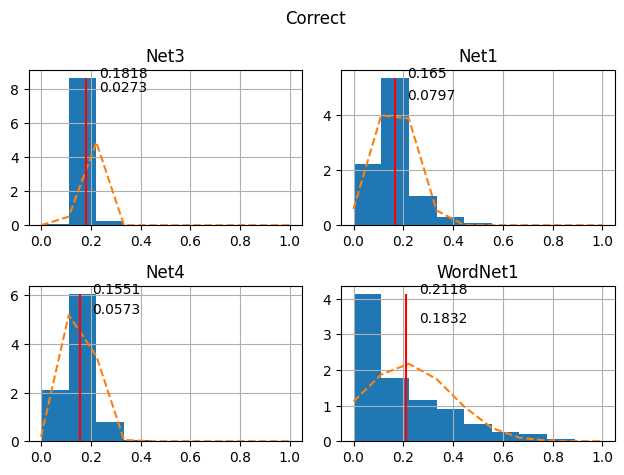

In [44]:
# "LatinFile.txt" simpler text
# eliminate net1, which seemed relatively ineffective
samples=500
charsPred=50
wordsPred=10
fig, axes = plt.subplots(2,2)
totCorrects = np.array([np.array([totCorrect_net3])/charsPred,np.array([totCorrect_net1])/charsPred,
                        np.array([totCorrect_net4])/charsPred,np.array([totCorrect_wordnet1])/wordsPred]).squeeze()
totBins=np.linspace(0,1,10)
netLabels = ["Net3","Net1","Net4","WordNet1"]
fig.suptitle("Correct")
for i in range(0,4):
    ax = axes.flat[i]
    n,bins,patches = ax.hist(totCorrects[i],bins=totBins, density=True)
    mean = np.mean(totCorrects[i])
    sigma = np.std(totCorrects[i])
    top = np.max(n)
    
    y=((1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*(1/sigma*(bins-mean))**2))
    ax.plot(bins,y,'--',label="Normal Dist.")
    
    ax.vlines(mean,0,top,"red",label="Mean")
    ax.annotate(str(np.around(mean,decimals=4)),xy=(mean+0.05,top))
    ax.annotate(str(np.around(sigma,decimals=4)),xy=(mean+0.05,top-.8))
    ax.set_title(netLabels[i])
    ax.grid(True)
plt.tight_layout();
plt.show;

Rescaling WordNet words predicted to a comparable amount of characters predicted:

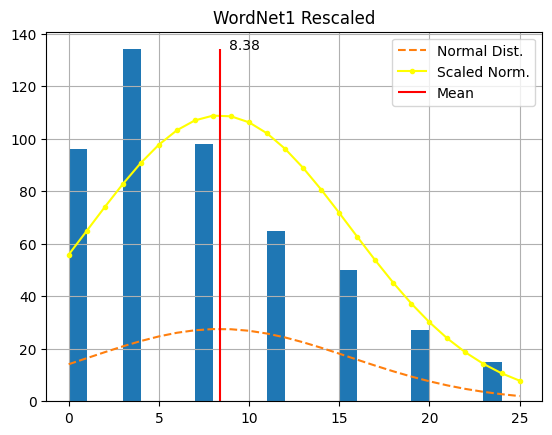

In [383]:
# wordnet1
avgWordLen = np.mean(np.array([len(i) for i in cds2.text]))
sampleSize = 500
rescaledTotCorrect = np.array(totCorrect_wordnet1)*avgWordLen
totBins=np.arange(0,25,1)
fig, ax = plt.subplots()
n,bins,patches = ax.hist(rescaledTotCorrect,,bins=totBins)

# Normal Distribution of the Data
mean = np.mean(rescaledTotCorrect)
sigma = np.std(rescaledTotCorrect)
y = sampleSize*((1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*(1/sigma*(bins-mean))**2))
ax.plot(bins,y,'--',label="Normal Dist.")

# Scaled Normal Distribution of the Data
z = avgWordLen*y
ax.plot(bins,z,'.-',color="yellow", label="Scaled Norm.")

# Sample Mean
ax.vlines(mean,0,np.max(n),"red",label="Mean")
ax.annotate(str(np.around(mean,decimals=2)),xy=(mean+0.5,np.max(n)))

ax.legend()
ax.set_title("WordNet1 Rescaled")
ax.grid(True)

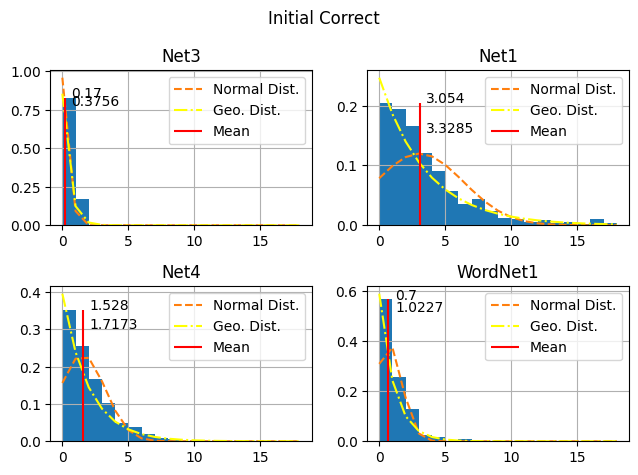

In [78]:
# "LatinFile.txt" simpler text
# eliminate net1, which seemed relatively ineffective
samples = 500
fig, axes = plt.subplots(2,2)
initCorrects = np.array([initCorrect_net3,initCorrect_net1,initCorrect_net4,initCorrect_wordnet1])
initBins = np.arange(0,np.max(initCorrects),1)
netLabels = ["Net3","Net1","Net4","WordNet1"]
fig.suptitle("Initial Correct")
for i in range(0,4):
    ax = axes.flat[i]
    n,bins,patches = ax.hist(initCorrects[i],bins=initBins,density=True)
    
    mean = np.mean(initCorrects[i])
    sigma = np.std(initCorrects[i])
    top = np.max(n)
    
    y=((1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*(1/sigma*(bins-mean))**2))
    ax.plot(bins,y,'--',label="Normal Dist.")
    
    
    # Geometric Distribution of Data
    failP = 1/(1+mean)
    z=((1-failP)**bins)*failP
    ax.plot(bins,z,'-.',color="yellow",label="Geo. Dist.")
    
    ax.vlines(mean,0,top,"red",label="Mean")
    ax.annotate(str(mean),xy=(mean+0.5,top))
    ax.annotate(str(np.around(sigma,decimals=4)),xy=(mean+0.5,top-0.05))
    
    ax.legend()
    ax.set_title(netLabels[i])
    ax.grid(True)
plt.tight_layout();
plt.show;

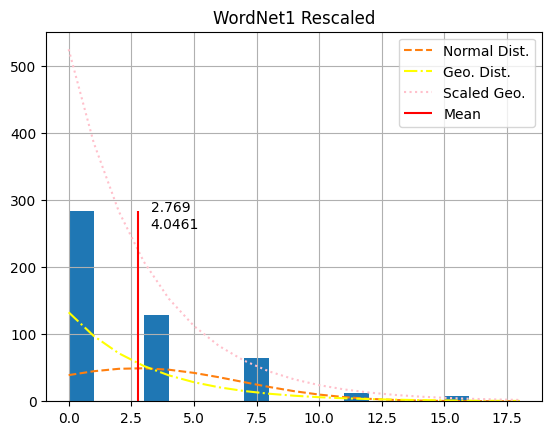

In [80]:
# wordnet1 rescaling
avgWordLen = np.mean(np.array([len(i) for i in cds2.text]))
sampleSize = 500
rescaledInitCorrect = np.array(initCorrect_wordnet1)*avgWordLen
fig, ax = plt.subplots()
n,bins,patches = ax.hist(rescaledInitCorrect,np.arange(0,np.max(initCorrects),1))

# Normal Distribution of the Data
mean = np.mean(rescaledInitCorrect)
sigma = np.std(rescaledInitCorrect)
y = sampleSize*((1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*(1/sigma*(bins-mean))**2))
ax.plot(bins,y,'--',label="Normal Dist.")

# Geometric Distribution of Data
failP = 1/(1+mean)
z=samples*((1-failP)**bins)*failP
ax.plot(bins,z,'-.',color="yellow",label="Geo. Dist.")

# Scaled Geometric Distribution of Data
w=avgWordLen*z
ax.plot(bins,w,':',color="pink",label="Scaled Geo.")

# Sample Mean
ax.vlines(mean,0,np.max(n),"red",label="Mean")
ax.annotate(str(np.around(mean,decimals=3)),xy=(mean+0.5,np.max(n)))
ax.annotate(str(np.around(sigma,decimals=4)),xy=(mean+0.5,np.max(n)-25))

ax.legend()
ax.set_title("WordNet1 Rescaled")
ax.grid(True)

A Gaussian model is sensible for Totals, a Geometric model sensible for Initials.

The scaled Normal and Geometric models account for the data centering around bins when scaled.

We compare these models to random guessing (0 weights) and global averaging (1 weight).

We could further compare to per char/word averaging (vocab_size weights), where for each char/word the predicted word is the most common one after it WRT the sample.

In [419]:
# Random guessing a Char
predictedChars = 50
totExpectation = predictedChars*1/cds.vocab_size; 
print(f'Correct Of {predictedChars} Guesses: {totExpectation}')
print(f'Random Total Percentage: {1/cds.vocab_size*100}%')

initExpectation = cds.vocab_size/(cds.vocab_size-1)-1; print(f'Init correct: {initExpectation}')


Correct Of 50 Guesses: 1.7857142857142858
Random Total Percentage: 3.571428571428571%
Init correct: 0.03703703703703698


In [420]:
# Random guessing a word
predictedWords=10
totExpectation = predictedWords*1/cds2.vocab_size; 
print(f'Correct Of {predictedWords} Guesses: {totExpectation}')
print(f'Random Total Percentage: {1/cds2.vocab_size*100}%')

initExpectation = cds2.vocab_size/(cds2.vocab_size-1)-1; print(f'Init correct: {initExpectation}')


Correct Of 10 Guesses: 0.05434782608695652
Random Total Percentage: 0.5434782608695652%
Init correct: 0.005464480874316946


In [413]:
# Get most common char
cds_chars = sorted(cds.text)
charDiffs = [i for i in range(1,len(cds_chars)) 
                 if cds_chars[i]!=cds_chars[i-1]]
charCts = [charDiffs[i]-charDiffs[i-1] 
                 for i in range(1,len(charDiffs))]
charCts.insert(0,charDiffs[0])
charCts.append(len(cds_chars)-charDiffs[-1])
maxChar = cds_chars[np.argmax(np.array(charCts))]
maxCharCt = np.max(charCts)
maxCharPercent = maxCharCt/len(cds_chars)
print(f'\"{maxChar}\" occurs {maxCharCt} times, or {maxCharPercent*100}% occurence')
print(f'E(Total Correct)={maxCharPercent*predictedChars}.')
print(f'E(Init Correct)={(maxCharPercent)/(1-maxCharPercent)}.')

" " occurs 329 times, or 18.503937007874015% occurence
E(Total Correct)=9.251968503937007.
E(Init Correct)=0.22705314009661837.


In [412]:
# Get most common word
predictedWords = 10

cds2_words = sorted(cds2.text)
wordDiffs = [i for i in range(1,len(cds2_words)) 
                 if cds2_words[i]!=cds2_words[i-1]]
wordCts = [wordDiffs[i]-wordDiffs[i-1] for i in range(1,len(wordDiffs))]
wordCts.insert(0,wordDiffs[0])
wordCts.append(len(cds2_words)-wordDiffs[-1])
maxWord = cds2_words[np.argmax(wordCts)]
maxWordCt = np.max(wordCts)
maxWordPercent = maxWordCt/len(cds2_words)
print(f'\"{maxWord}\" occurs {maxWordCt} times or {maxWordPercent*100}% occurence.')
print(f'E(Total Correct)={maxWordPercent*predictedWords}.')
print(f'E(Init Correct)={(maxWordPercent)/(1-maxWordPercent)}.')

"." occurs 29 times or 7.9452054794520555% occurence.
E(Total Correct)=0.7945205479452055.
E(Init Correct)=0.08630952380952382.


In [426]:
for i in range(0,4):
    print(netLabels[i])
    print(f'Tot Mean:{np.mean(totCorrects[i])} ,Tot. Std:{np.std(totCorrects[i])}')
    print(f'Init Mean:{np.mean(initCorrects[i])} ,Init. Std:{np.std(initCorrects[i])}')

Net3
Tot Mean:9.186 ,Tot. Std:1.4097531698847143
Init Mean:0.202 ,Init. Std:0.4014922166119787
Net1
Tot Mean:8.248 ,Tot. Std:3.987291812747093
Init Mean:3.054 ,Init. Std:3.3285257998098796
Net4
Tot Mean:7.754 ,Tot. Std:2.8666154258986327
Init Mean:1.528 ,Init. Std:1.7173281573420962
WordNet1
Tot Mean:2.118 ,Tot. Std:1.831959606541585
Init Mean:0.7 ,Init. Std:1.0227414140436477


Defining some terms below for our models:

`Total Mean` is the average percentage of total characters/words guessed.

`Initial Mean` is the average percentage of a character/word correctly guessed correctly to start. E.g. a value of 300% would refer to an average of 3 characters guessed correctly to start.

`Train Time` refers to how long it takes to train the model.

|                  | Total Mean | Total SD | Initial Mean | Initial SD | Train Time |
|------------------|------------|----------|--------------|------------|------------|
| random  char     | 3.57%      | --       | 3.70%        | --         | --         |
| 1 weight char    | 18.5%      | --       | 22.7%        | --         | --         |
| net3             | 18.2%      | 2.7%     | 17%          | 37.6%      | 20:54      |
| net1             | 16.5%      | 8.0%     | 305.4%       | 332.9%     | 4:48       |
| net4             | 15.5%      | 5.7%     | 152.8%       | 171.77%    | 11:34      |
| random word      | 0.54%      | --       | 0.55%        | --         | --         |
| 1 weight word    | 7.95%      | --       | 8.63%        | --         | --         |
| wordnet1         | 21.18%     | 1.83     | 70%          | 102.3%     | 4:05       |
| ->Char    Scaled |            |          | 277.0%       | 404.6%     |            |

Hypothesis testing whether the models are "useful" by testing if the global averaging model could occur within the range of feasible models generated.

For this we select the apparently well-performing `net1` model. We use the reasonable assumptions that `Total Mean` follows a Gaussian distribution and `Initial Mean` follows a Geometric distribution.

In [2]:
import scipy.stats as stats

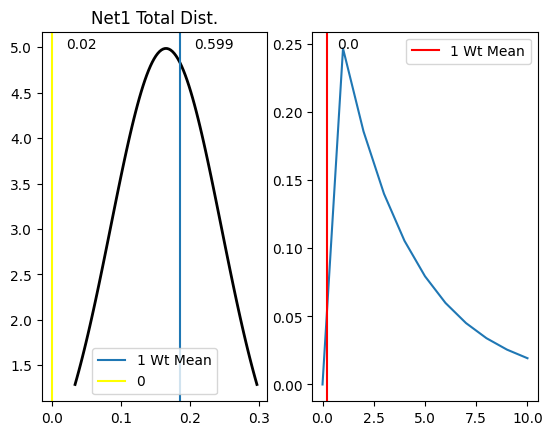

In [26]:
net1Mean=.165
net1SD=.08
oneWtMean=.185

# Total Correct
TotalMeanDist = stats.norm(loc=net1Mean,scale=net1SD)
x = np.linspace(TotalMeanDist.ppf(0.05), TotalMeanDist.ppf(0.95), 100)
y=TotalMeanDist.pdf(x)

fig, axes = plt.subplots(1, 2)


axes[0].plot(x, y, 'k-', lw=2);
axes[0].set_title("Net1 Total Dist.");
# 1 Wt Line
axes[0].axvline(oneWtMean,label="1 Wt Mean")
axes[0].annotate(str(np.around(TotalMeanDist.cdf(oneWtMean),decimals=3)),
                 xy=(oneWtMean+0.02,np.max(y)))
# 0 Line, to subtract from
axes[0].axvline(0,color="yellow",label="0")
axes[0].annotate(str(np.around(TotalMeanDist.cdf(0),decimals=3)),
                 xy=(0+0.02,np.max(y)))
axes[0].legend();

# Initial Correct
net1InitMean=3.054
p=1/(1+net1InitMean)
net1InitSD=3.329
oneWtInitMean=0.227

InitMeanDist = stats.geom(p)
z=np.arange(0,InitMeanDist.ppf(0.95))
w=InitMeanDist.pmf(z)

axes[1].plot(z,w)
axes[1].axvline(oneWtInitMean,label="1 Wt Mean",color="red")
axes[1].annotate(str(np.around(InitMeanDist.cdf(oneWtInitMean),decimals=3)),
                 xy=(oneWtInitMean+0.5,max(w)))
axes[1].legend();

Then we see `40.3`% of `net1` predictions do better in total correct words, compared with simply taking the global average. On average, `0.3`% fewer total words predicted correctly.

But essentially `100`% of `net1` predictions do better in initial correct words, compared with simply taking the global average. On average, 2.827 more words initially correctly predicted.


We can also try prompting the word based `wordnet1` GRU with some new sentences, but same vocabulary, and see to what degree it produces sensible output.

In [42]:
# Recall vocab
print(sorted(set(cds2.text)))

['.', 'a', 'about', 'agree', 'aki', 'all', 'already', 'also', 'always', 'and', 'arc', 'are', 'at', 'b', 'bae', 'battles', 'be', 'been', 'before', 'begging', 'bust', 'but', 'c', 'can', 'cant', 'carry', 'chan', 'chance', 'chaos', 'cheer', 'combinations', 'commentator', 'competition', 'continue', 'cooler', 'decreases', 'did', 'doing', 'dont', 'draw', 'editing', 'ending', 'enjoyed', 'event', 'ever', 'everyone', 'everything', 'f', 'farming', 'feeling', 'finished', 'first', 'fitness', 'for', 'forward', 'from', 'fun', 'ganbatte', 'gbf', 'get', 'gets', 'getting', 'given', 'glad', 'go', 'gonna', 'good', 'guild', 'hard', 'has', 'have', 'help', 'her', 'high', 'hime', 'hololive', 'holomembers', 'holomen', 'hope', 'how', 'hype', 'i', 'if', 'im', 'in', 'ina', 'interested', 'interesting', 'it', 'its', 'just', 'know', 'last', 'left', 'level', 'like', 'little', 'lol', 'long', 'look', 'looking', 'luck', 'luna', 'mario', 'maybe', 'more', 'muscles', 'need', 'new', 'not', 'nutrition', 'o', 'of', 'on', 'one

In [56]:
# Choose a prompt
prompt = "im so very looking forward to your sexy swimsuit .".split()
rs = cds2.read_seq
n = 10
# Feed seq to net, ask for next n chars
pred_seq = wordnet1.predict(cds2.encode_seq(prompt),
                            primingLength = primingLength, n=n).cpu()
print(f'Prediction:   {rs(s)+" "+colored(rs(pred_seq), "red")}')

Prediction:   im so very looking forward to your sexy swimsuit . . o looking forward to looking forward to the raffle


Input 10 (pre-existing) words seperated by spaces as a prompt.

Idea to make more user friendly: allows variable prompt length (add padding at front)

Idea to improve predictions: larger and more diverse sample, word2vec encoding of words to account for synonyms

In [59]:
prompt = input()
pred_seq = wordnet1.predict(cds2.encode_seq(prompt.split()),
                            primingLength = primingLength, n=n).cpu()
print(f'Prediction:   {rs(s)+" "+colored(rs(pred_seq), "red")}')

i like working out . i need more muscles .
Prediction:   im so very looking forward to your sexy swimsuit . on a on a arc and bae are look towa
